<a href="https://colab.research.google.com/github/kundajelab/dragonn/blob/master/paper_supplement/PrimerTutorial%205%20-%20Functional%20variant%20characterization%20for%20non-coding%20SNPs%20within%20the%20SPI1%20motif.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Split : classification vs regression; bQTL dataset 
# remove Isotonic Regression. spearman/pearson on non-calibrated values 
# upsample the peak regions for regression models. 
#difference log probs 
# scatter plots in log space for the bQTL data. 
# density plot of logratio vs logodds prediction. 

#GC_fraction = pwm_background
#add a line for 0 in pfm plot 
# 4 cell lines for SPI1: 

# GM12878
# GM12891
# HL-60
# K562



# How to train your DragoNN tutorial 5: 
## Functional variant characterization for non-coding SNPs within the SPI1 motif 

This tutorial is a supplement to the DragoNN manuscript. 

This tutorial will take 2 - 3 hours if executed on a GPU.

## Outline<a name='outline'>
<ol>
    <li><a href=#1>Input data: SPI1 ChiP-seq and experimental bQTL data</a></li>
    <li><a href=#2>Genomewide classification and regression labels for SPI1 TF ChiPseq</a></li>
    <li><a href=#3>Optional: Download pre-generated models and test-set predictions</a></li>
    <li><a href=#4>Genome-wide classification for SPI1</a></li>
    <li><a href=#5>Calibrate model predictions with Platt Scaling</a></li>
    <li><a href=#6>Genome-wide regression for SPI1</a></li> 
    <li><a href=#7>Calibrate model predictions with Isotonic Regression</a></li> 
    <li><a href=#8>Save tutorial outputs (models/predictions)</a></li>     
    <li><a href=#9>Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT</a></li>
    <li><a href=#10>Applications for SPI1 bQTL dataset</a></li>
    <ol>
        <li><a href=#a>Read in and annotate SPI1 bQTL dataset</a></li>
        <li><a href=#b>Obatin DNN predictions for POST and ALT alleles within the bQTL dataset</a></li>
        <li><a href=#c>Compare model predictions on POST and ALT alleles </a></li>
        <li><a href=#d>bQTL dataset motif scan with HOCOMOCO SPI1 motif </a></li>
        <li><a href=#e>bQTL interpretation summary: deep learning models vs motif scan</a></li>
    </ol>
    <li><a href=#11>Deep learning models are able to identify low-affinity TF-binding sites missed by motif scanning.</a></li>
</ol>
Github issues on the [dragonn repository](https://github.com/kundajelab/dragonn) with feedback, questions, and discussion are always welcome.


In [2]:
# If you don't have bedtools installed in your environment (i.e. Google Colab), uncomment and run the command below 
#!apt-get install bedtools
#!pip install pybedtools

In [3]:
#uncomment the lines below if you are running this tutorial from Google Colab 
#!pip install dragonn>=0.2.6

In [4]:
# Making sure our results are reproducible
from numpy.random import seed
seed(1234)
from tensorflow import set_random_seed
set_random_seed(1234)

In [5]:
from keras import backend as K
import tensorflow as tf
s=tf.Session()

Using TensorFlow backend.


In [6]:
#load dragonn tutorial utilities 
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


## Input data <a name='1'>
<a href=#outline>Home</a>

This tutorial uses the same in vivo SPI1 transcription factor CHiP-seq dataset that was used in [Tutorial 4](https://colab.research.google.com/github/kundajelab/dragonn/blob/keras_2.2_tensorflow_1.6_purekeras/paper_supplement/PrimerTutorial%204%20-%20Interpreting%20predictive%20sequence%20features%20in%20in-vivo%20TF%20binding%20events.ipynb). Our goal is to compare predicted variant effect sizes from classification and regression models against experimental bQTL data. The bQTL data in this way serves as a "gold-standard" validation that in silico mutagenesis on the deep learning inputs leads to correct variant effect size prediction.  We  will use bQTL data  that has been intersected with SPI1 CISBP genome motif annotations. 

In [ ]:
# SPI1, optimal IDR thresholded peaks, Myers lab, hg19
# https://www.encodeproject.org/experiments/ENCSR000BGQ/
!wget -O SPI1.narrowPeak.gz http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-reproducibility_idr/execution/optimal_peak.regionPeak.gz

#Fold change bigWig track for the SPI1 dataset: 
!wget -O SPI1.pooled.fc.bigWig http://mitra.stanford.edu/kundaje/projects/dragonn/dragonn_gm12878_pipeline/spi1_ENCSR000BGQ/cromwell-executions/chip/bb0c3c5a-3889-43fe-a218-05851cecc74a/call-macs2_pooled/execution/ENCFF000OBU.Rep1.merged.nodup.pooled_x_ENCFF000OCW.Control.Rep1.merged.nodup.fc.signal.bigwig
    
## Download "ambiguous" peak sets -- these peaks are in the optimal overlap set across replicates, but are not
## found to be reproducible at a high confidence (p<0.05) by IDR 
! wget -O SPI1.ambiguous.gz http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.ambiguous.gz

## Download the hg19 chromsizes file (We only use chroms 1 -22, X, Y for training)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.chrom.sizes
    
## Download the hg19 fasta reference genome (and corresponding .fai index)
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.fai 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/hg19.genome.fa.gz.gzi 

    




In [ ]:
# Download bQTL experimental data for SPI1 loci 
!wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.bQTLs.txt.gz

## Generating genome-wide classification and regression labels <a name='2'>
<a href=#outline>Home</a>

We will use the *genomewide_labels* function from the  [seqdataloader](https://github.com/kundajelab/seqdataloader) package to generate positive and negative labels for the TF-ChIPseq peaks across the genome. We will treat each sample as a task for the model and compare the performance of the model on SPI1 task in the single-tasked and multi-tasked setting.

In [12]:
from seqdataloader import * 

In [13]:
## seqdataloader accepts an input file, which we call SPI1.tasks.tsv, with task names in column 1, corresponding
## peak files in column 2, and the signal track in column 3. In this tutorial, the task file will have a single task entry for the SPI1 TF CHiP-seq
with open("SPI1.task.tsv",'w') as f: 
    f.write("SPI1\tSPI1.narrowPeak.gz\tSPI1.pooled.fc.bigWig\tSPI1.ambiguous.gz\n")
f.close() 
!cat SPI1.task.tsv

SPI1	SPI1.narrowPeak.gz	SPI1.pooled.fc.bigWig	SPI1.ambiguous.gz


With the parameter configuration below, seqdataloader splits the genome into 1kb regions, with a stride of 50. Each 1kb region is centered at a 200 bp bin, with a left flank of 400 bases and a right flank of 400 bases. 

* In the classification case, each 200 bp bin is labeled as positive if a narrowPeak summit overlaps with it. The bin is labeled negative if there is no overlap with the narrowPeak. 
* In the regression case, the asinh(mean coverage) in the 200 bp bin is computed. 


In [ ]:
!cat SPI1.task.tsv

**Note**: The label generation may take 10 - 15 minutes to complete. If you prefer not to wait, you can download the 
pre-generated classification and regression labels for the training, validation, and test sets by uncommenting the code below: 

In [ ]:
## Classification labels 
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.classification.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.classification.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.classification.hdf5

## Regression labels 
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.train.regression.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.valid.regression.hdf5
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.test.regression.hdf5


If you prefer to generate the labels from scratch, execute the two code cell below: 

In [ ]:
#  Generate genome-wide classification labels 

#1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set. Also, the dataset does not
# include chromosome Y, so we exclude it as well. 

train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.classification.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'peak_summit_in_bin_classification'
    }
genomewide_labels(test_set_params)


In [ ]:
# Generate regression labels genome-wide 

#1) Training set: all chromosomes with the exception of 1,2, and 19 in our training set 

train_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.train.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_exclude':['chr1','chr2','chr19','chrY'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':4,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(train_set_params)

#2) Validation set: Chromosome 1
valid_set_params={'task_list':"SPI1.task.tsv",
    'outf':"SPI1.valid.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':'chr1',
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':1,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(valid_set_params)

#3) Test set: Chromosomes 2, 19 
test_set_params={
    'task_list':"SPI1.task.tsv",
    'outf':"SPI1.test.regression.hdf5",
    'output_type':'hdf5',
    'chrom_sizes':'hg19.chrom.sizes',
    'chroms_to_keep':['chr2','chr19'],
    'bin_stride':50,
    'left_flank':400,
    'right_flank':400,
    'bin_size':200,
    'threads':2,
    'subthreads':4,
    'allow_ambiguous':True,
    'labeling_approach':'all_genome_bins_regression'
    }
genomewide_labels(test_set_params)


Let's examine the files that were generated: 

In [14]:
#The code generates bed file outputs with a label of 1 or 0 for each 1kb
# genome bin for each task. Note that the bins are shifted with a stride of 50.
pd.read_hdf("SPI1.train.classification.hdf5",start=1000000,stop=1000010)

SPI1
CHR  START    END           
chr3 50000000 50001000   0.0
     50000050 50001050   0.0
     50000100 50001100   0.0
     50000150 50001150   0.0
     50000200 50001200   0.0
     50000250 50001250   0.0
     50000300 50001300   0.0
     50000350 50001350   0.0
     50000400 50001400   0.0
     50000450 50001450   0.0

In [15]:
pd.read_hdf("SPI1.train.regression.hdf5",start=1000000,stop=1000010)

SPI1
CHR  START    END               
chr3 50000000 50001000  0.287037
     50000050 50001050  0.436855
     50000100 50001100  0.491599
     50000150 50001150  0.460063
     50000200 50001200  0.460063
     50000250 50001250  0.460063
     50000300 50001300  0.491599
     50000350 50001350  0.519880
     50000400 50001400  0.633077
     50000450 50001450  0.709212

## Optional: Download pre-generated models and test-set predictions <a name='3'>
<a href=#outline>Home</a>

Next, we will train classification and regression models to predict TF CHiP-seq peaks for SPI1. If you want to skip straight to model interpretation and bQTL analysis, you can download the pre-trained models by uncommenting the 
block of code below. 

In [23]:
from keras.models import load_model 
from dragonn.custom_losses import get_ambig_binary_crossentropy, get_ambig_mean_squared_error
from dragonn.metrics import * 
from dragonn.models import load_dragonn_model 

## Download classification model 
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.classification.model.hdf5
spi1_classification_model=load_dragonn_model("SPI1.classification.model.hdf5")

## Download regression model 
! wget http://mitra.stanford.edu/kundaje/projects/dragonn/SPI1.regression.model.hdf5
spi1_regression_model=load_dragonn_model("SPI1.regression.model.hdf5")


## Get test set classification model and regression model predictions 
import h5py
test_set=h5py.File("SPI1.test.predictions.hdf5")

#extract the labels for the classification and regression test sets
spi1_test_classification_labels=test_set['classification_labels']
spi1_test_regression_labels=test_set['regression_labels']

spi1_test_classification_predictions=test_set['classification_postactivation']
spi1_test_classification_calibrated_predictions=test_set['classification_postactivation_calibrated']
spi1_test_classification_logits=test_set['classification_preactivation']
spi1_test_regression_predictions=test_set['regression']
spi1_test_regression_calibrated_predictions=test_set['regression_calibrated']

In [218]:

## Get test set classification model and regression model predictions 
import h5py
test_set=h5py.File("SPI1.test.predictions.hdf5")

#extract the labels for the classification and regression test sets
spi1_test_classification_labels=test_set['classification_labels']
spi1_test_regression_labels=test_set['regression_labels']

spi1_test_classification_predictions=test_set['classification_postactivation']
spi1_test_classification_calibrated_predictions=test_set['classification_postactivation_calibrated']
spi1_test_classification_logits=test_set['classification_preactivation']
spi1_test_regression_predictions=test_set['regression']
spi1_test_regression_calibrated_predictions=test_set['regression_calibrated']

## Genome-wide classification model <a name='4'>
<a href=#outline>Home</a>


In [24]:
#To prepare for model training, we import the necessary functions and submodules from keras
from keras.models import Sequential
from keras.layers.core import Dropout, Reshape, Dense, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import Adadelta, SGD, RMSprop;
import keras.losses;
from keras.constraints import maxnorm;
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, History
from keras import backend as K 
K.set_image_data_format('channels_last')

In [25]:
from dragonn.runtime_metrics import precision, recall, specificity, fpr, fnr, fdr, f1
from keras.constraints import max_norm
from dragonn.custom_losses import get_ambig_binary_crossentropy
def initialize_classification_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))
    model.add(Activation("sigmoid"))
    
    #use the custom ambig_binary_crossentropy loss, indicating that a value of np.nan indicates an ambiguous label 
    loss=get_ambig_binary_crossentropy()
    
    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam', loss=loss,
                  metrics=[precision,
                          recall,
                          specificity,
                          fpr,
                          fnr,
                          fdr,
                          f1])
    return model

We create generators for the training and validation data: 

In [10]:
#create the generators, upsample positives to ensure they constitute 30% of each batch 
from dragonn.generators import * 
spi1_train_classification_gen=DataGenerator("SPI1.train.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3, batch_size=256)
spi1_valid_classification_gen=DataGenerator("SPI1.valid.classification.hdf5","hg19.genome.fa.gz",upsample_ratio=0.01, batch_size=256)


In [11]:
#Train the SPI1 classification model 
spi1_classification_model=initialize_classification_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_classification=spi1_classification_model.fit_generator(spi1_train_classification_gen,
                                                  validation_data=spi1_valid_classification_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 416s 42ms/step - loss: 0.1403 - precision: 0.9015 - recall: 0.9188 - specificity: 0.9559 - fpr: 0.0440 - fnr: 0.0811 - fdr: 0.0984 - f1: 0.9042 - val_loss: 0.0675 - val_precision: 0.2366 - val_recall: 0.8494 - val_specificity: 0.9739 - val_fpr: 0.0261 - val_fnr: 0.1457 - val_fdr: 0.7607 - val_f1: 0.3537
Epoch 2/150
10000/10000 [==============================] - 393s 39ms/step - loss: 0.0958 - precision: 0.9300 - recall: 0.9534 - specificity: 0.9692 - fpr: 0.0307 - fnr: 0.0464 - fdr: 0.0699 - f1: 0.9362 - val_loss: 0.0633 - val_precision: 0.2569 - val_recall: 0.8576 - val_specificity: 0.9757 - val_fpr: 0.0243 - val_fnr: 0.1374 - val_fdr: 0.7412 - val_f1: 0.3753
Epoch 3/150
10000/10000 [==============================] - 394s 39ms/step - loss: 0.0817 - precision: 0.9379 - recall: 0.9656 - specificity: 0.9726 - fpr: 0.0274 - fnr: 0.0343 - fdr: 0.0619 - f1: 0.9462 - val_loss: 0.0813 - val_precision: 0.2105 - val_recall: 0.8828 - val

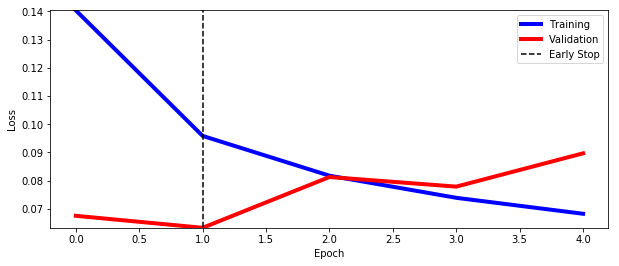

In [12]:
## Plot the learning curves for SPI1  
from dragonn.vis import *
plot_learning_curve(history_classification)

In [16]:
#Save the classification model so it can be loaded more readily in the future. 
spi1_classification_model.save("SPI1.classification.model.hdf5")


We now measure how well the model performed by calculating performance metrics on the test splits across the whole genome. 

In [44]:
from dragonn.generators import * 
spi1_test_classification_gen=DataGenerator("SPI1.test.classification.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])


In [46]:
spi1_test_classification_predictions=spi1_classification_model.predict_generator(spi1_test_classification_gen,
                                                                                 max_queue_size=5000,
                                                                                 workers=40,
                                                                                 use_multiprocessing=True,
                                                                                 verbose=1)

6047/6047 [==============================] - 413s 68ms/step


In [50]:
spi1_test_classification_labels=spi1_test_classification_gen.data
print(spi1_test_classification_predictions.shape) 
print(spi1_test_classification_labels.shape)

(6046528, 1)
(6046528, 1)


In [51]:
#remove nans, as they corresponnd to ambiguous values 
nan_indices=np.isnan(spi1_test_classification_labels.values.astype(bool))

In [52]:
nan_indices.shape

(6046528, 1)

In [53]:
spi1_test_classification_labels=spi1_test_classification_labels[~nan_indices]
spi1_test_classification_predictions=np.expand_dims(spi1_test_classification_predictions[~nan_indices],axis=1)

In [54]:
## Generate a ClassificationResult object to print performance metrics on held-out test set 
from dragonn.metrics import ClassificationResult
print(ClassificationResult(spi1_test_classification_labels.values.astype(bool),
                           spi1_test_classification_predictions))

Loss: nan	Balanced Accuracy: 87.14%	 auROC: 0.975	 auPRC Careful: 0.357	 auPRC Trapezoidal: 0.357
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|3.4%	 Num Positives: 30779	 Num Negatives: 6015749


## Calibrate the model predictions with Platt scaling  <a name='5'>
<a href=#outline>Home</a>

The next step is to calibrate the model predictions such that a threshold of 0.5 can be used to determine whether a prediction should round up to 1 (True) or down to 0 (False). The [Platt scaling algorithm](https://en.wikipedia.org/wiki/Platt_scaling) can be used to transform the outputs of our classification model into a probability distribution over different classes. 

In [62]:
#calibration will be performed on the logits of the model, so we use a trick to obtain these logits --
# we create a new model that wraps around "spi1_classification_model" and provides the logits (layer -2)
from keras.models import Model 
target_layer_idx=-2
classification_preact_model=Model(inputs=spi1_classification_model.input,
                   outputs=spi1_classification_model.layers[target_layer_idx].output)


In [63]:
#We now reset the test set generator and obtain the prediction logits from the preact model. 
# It is important to reset the generator to preserve the order of the input samples. 
spi1_test_classification_gen=DataGenerator("SPI1.test.classification.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])

In [64]:
spi1_test_classification_logits=classification_preact_model.predict_generator(spi1_test_classification_gen,
                                                                          max_queue_size=5000,
                                                                          workers=40,
                                                                          use_multiprocessing=True,
                                                                          verbose=1)

6047/6047 [==============================] - 404s 67ms/step


In [219]:
#We obtain the Platt Scaling calibration function 
from dragonn.calibration import * 
classification_calibration_funcs=get_calibration_function_classification(spi1_test_classification_logits,
                                                     spi1_test_classification_gen.data)

Platt scaling coef: 0.5741696976216163 ; intercept: -3.275310453133998


In [70]:
#We use the Platt Scaling calibration function to obtain calibrated predictions on the test set 
spi1_test_classification_calibrated_predictions=get_calibrated_predictions(spi1_test_classification_logits,
                                                                           classification_calibration_funcs)

(6046528, 1)


In [73]:
spi1_test_classification_calibrated_predictions=np.expand_dims(spi1_test_classification_calibrated_predictions[~nan_indices],axis=1)
print(ClassificationResult(spi1_test_classification_labels.values.astype(bool),
                           spi1_test_classification_calibrated_predictions))

Loss: 0.0163	Balanced Accuracy: 57.43%	 auROC: 0.975	 auPRC Careful: 0.357	 auPRC Trapezoidal: 0.357
	Recall at 5%|10%|20% FDR: 0.0%|0.0%|3.4%	 Num Positives: 30779	 Num Negatives: 6015749


Note that most of the metrics have not changed, with the exception of Balanced Accuracy. This value decreased to 57.43%, 
reflecting the calibrated threshold for separating positive and negative predictions. 

## Genome-wide regression model <a name='6'>
<a href=#outline>Home</a>

In [74]:
from dragonn.custom_losses import get_ambig_mean_squared_error
def initialize_regression_model(ntasks=1):
    #Define the model architecture in keras (regularized, 3-layer convolution model followed by 1 dense layer)
    model=Sequential() 
    
    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same", kernel_constraint=max_norm(7.0,axis=-1),input_shape=(1,1000,4)))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,15),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))

    model.add(Conv2D(filters=50,kernel_size=(1,13),padding="same"))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size=(1,40)))
    
    model.add(Flatten())
    model.add(Dense(50))
    model.add(BatchNormalization(axis=-1))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(ntasks))

    loss=get_ambig_mean_squared_error()
    ##compile the model, specifying the Adam optimizer, and binary cross-entropy loss. 
    model.compile(optimizer='adam',loss=loss)
    return model

(4010730, 1)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f487082b9e8>]],
      dtype=object)

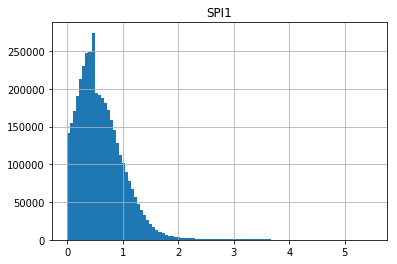

In [75]:
#we want to determine a threshold for upsampling the non-zero bins in a given batch 
# extract 5 million datapoints from the training data and observe the distribution of non-zero signal values  
sample=pd.read_hdf("SPI1.train.regression.hdf5",start=0,stop=5000000)
nonzero_sample=sample[sample.max(axis=1)>0]
print(nonzero_sample.shape)
nonzero_sample.hist(bins=100)

This suggests that 1 is a reasonable threshold for upsampling signal bins in regression 

In [76]:
#create the generators, no upsampling of positives is used for regression. 
from dragonn.generators import * 
spi1_train_regression_gen=DataGenerator("SPI1.train.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.3,upsample_thresh=1)
spi1_valid_regression_gen=DataGenerator("SPI1.valid.regression.hdf5","hg19.genome.fa.gz",upsample_ratio=0.01,upsample_thresh=1)


In [77]:
#Train the SPI1 regression model 
spi1_regression_model=initialize_regression_model()

## use the keras fit_generator function to train the model with early stopping after 3 epochs 
history_regression=spi1_regression_model.fit_generator(spi1_train_regression_gen,
                                                  validation_data=spi1_valid_regression_gen,
                                                  steps_per_epoch=10000,
                                                  validation_steps=5000,
                                                  epochs=150,
                                                  verbose=1,
                                                  use_multiprocessing=True,
                                                  workers=40,
                                                  max_queue_size=100,
                                                  callbacks=[EarlyStopping(patience=3,restore_best_weights=True),History()])

Epoch 1/150
10000/10000 [==============================] - 286s 29ms/step - loss: 0.2389 - val_loss: 0.1438
Epoch 2/150
10000/10000 [==============================] - 230s 23ms/step - loss: 0.1997 - val_loss: 0.1278
Epoch 3/150
10000/10000 [==============================] - 231s 23ms/step - loss: 0.1932 - val_loss: 0.1385
Epoch 4/150
10000/10000 [==============================] - 231s 23ms/step - loss: 0.1887 - val_loss: 0.1316
Epoch 5/150
10000/10000 [==============================] - 231s 23ms/step - loss: 0.1883 - val_loss: 0.1394


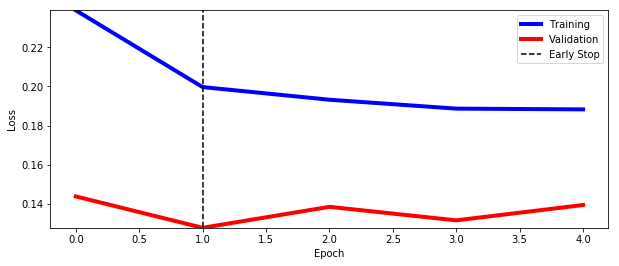

In [79]:
from dragonn.vis import *
plot_learning_curve(history_regression)

In [80]:
#Save the regression model so it can be loaded more readily in the future. 
spi1_regression_model.save("SPI1.regression.model.hdf5")


In [82]:
#Get predictions on the test set 
from dragonn.generators import * 
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])

In [83]:
spi1_test_regression_predictions=spi1_regression_model.predict_generator(spi1_test_regression_gen,
                                                                         max_queue_size=5000,
                                                                         workers=40,
                                                                         use_multiprocessing=True,
                                                                         verbose=1)

6047/6047 [==============================] - 353s 58ms/step


In [84]:
spi1_test_regression_labels=spi1_test_regression_gen.data
spi1_test_regression_predictions=np.expand_dims(spi1_test_regression_predictions,axis=1)

In [87]:
#remove nans, as they corresponnd to ambiguous values 
spi1_test_regression_labels=spi1_test_regression_labels[~nan_indices]
spi1_test_regression_predictions=spi1_test_regression_predictions[~nan_indices]

## Regression model calibration with Isotonic Regression  <a name='7'>
<a href=#outline>Home</a>

For a regression model, we can calibrate predictions via [Isotonic Regression](https://scikit-learn.org/stable/modules/calibration.html). The approach is very similar to the one we used for the SPI1 classification model above. 

In [88]:
#Create a model to return the preactivation (input to the final ReLU) for the regression model. 
target_layer_idx=-1
regression_preact_model=Model(inputs=spi1_regression_model.input,
                   outputs=spi1_regression_model.layers[target_layer_idx].output)


In [89]:
#Reinitialize our test data generator for prediction. 
spi1_test_regression_gen=DataGenerator("SPI1.test.regression.hdf5",
                                       "hg19.genome.fa.gz",
                                         upsample=False,
                                         add_revcomp=False,
                                         batch_size=1000,
                                         tasks=['SPI1'])

In [90]:
#use a predict_generator on the regression preactivation model to get the pre-activation values. 
spi1_test_regression_preacts=regression_preact_model.predict_generator(spi1_test_regression_gen,
                                                                         max_queue_size=5000,
                                                                         workers=40,
                                                                         use_multiprocessing=True,
                                                                         verbose=1)

6047/6047 [==============================] - 364s 60ms/step


In [220]:
#We obtain the Isotonic Regression  calibration function 
regression_calibration_funcs=get_calibration_function_classification(spi1_test_regression_preacts,
                                                     spi1_test_regression_gen.data)

Platt scaling coef: 4.118703499731541 ; intercept: -0.6530135923411943


In [103]:
#We use the Isotonic Regression calibration function to obtain calibrated predictions on the test set 
spi1_test_regression_calibrated_predictions=get_calibrated_predictions(spi1_test_regression_preacts,
                                                                           regression_calibration_funcs)

(6046528, 1)


In [104]:
## find the indices of the non-zero coverage bins 
nonzero_bins=spi1_test_regression_labels.max(axis=1)>0

In [105]:
spi1_test_regression_calibrated_predictions.shape

(6046528, 1)

In [106]:
#Calculate spearman and pearson correlation between truth labels and predictions 
from scipy.stats import pearsonr, spearmanr
corr_pearson=pearsonr(spi1_test_regression_labels,spi1_test_regression_calibrated_predictions)
corr_spearman=spearmanr(spi1_test_regression_labels,spi1_test_regression_calibrated_predictions)
print("Pearson correlation on test set:"+str(corr_pearson))
print("Spearman correlation on test set:"+str(corr_spearman))

Pearson correlation on test set:(array([0.49455556]), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.5404596080756828, pvalue=0.0)


In [107]:
# Calculate the spearman and pearson correlation, restricted to non-zero bins 
corr_pearson_nonzero_bins=pearsonr(spi1_test_regression_labels[nonzero_bins],spi1_test_regression_calibrated_predictions[nonzero_bins])
corr_spearman_nonzero_bins=spearmanr(spi1_test_regression_labels[nonzero_bins],spi1_test_regression_calibrated_predictions[nonzero_bins])
print("Pearson correlation on test set:"+str(corr_pearson_nonzero_bins))
print("Spearman correlation on test set:"+str(corr_spearman_nonzero_bins))

Pearson correlation on test set:(array([0.41316202]), array([0.]))
Spearman correlation on test set:SpearmanrResult(correlation=0.4461033630225201, pvalue=0.0)


In [108]:
test_df=pd.DataFrame({"Observed":list(spi1_test_regression_labels.values.squeeze()),
                     "Predicted":list(spi1_test_regression_calibrated_predictions.squeeze())})

In [110]:
test_df_nonzero=pd.DataFrame({"Observed":list(spi1_test_regression_labels[nonzero_bins].values.squeeze()),
                     "Predicted":list(spi1_test_regression_calibrated_predictions[nonzero_bins].squeeze())})

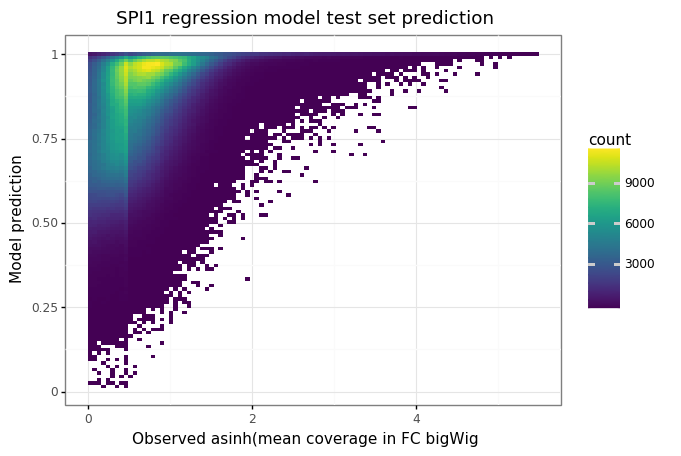

<ggplot: (8746796477816)>


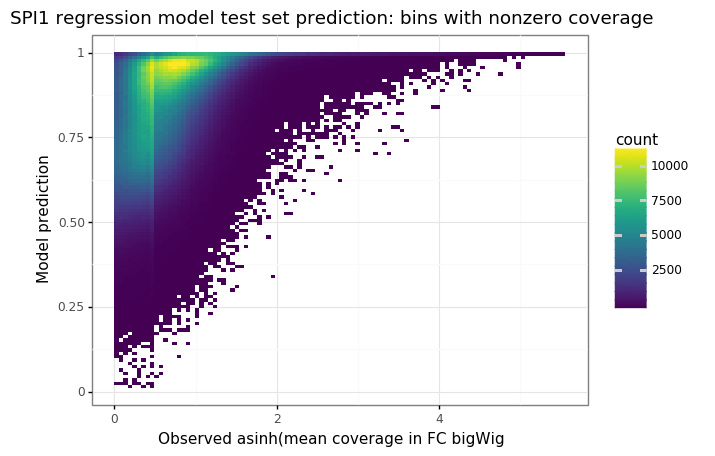

<ggplot: (8746763264253)>


In [111]:
import plotnine 
from plotnine import * 
print((ggplot(test_df,aes(x="Observed",y="Predicted"))
 +geom_bin2d(bins=100)
 +theme_bw()
 +xlab("Observed asinh(mean coverage in FC bigWig")
 +ylab("Model prediction")
 +ggtitle("SPI1 regression model test set prediction")))

print((ggplot(test_df_nonzero,aes(x="Observed",y="Predicted"))
 +geom_bin2d(bins=100)
 +theme_bw()
 +xlab("Observed asinh(mean coverage in FC bigWig")
 +ylab("Model prediction")
 +ggtitle("SPI1 regression model test set prediction: bins with nonzero coverage")))

## Save tutorial outputs <a name='8'>
    
<a href=#outline>Home</a>

We save the models and test set predictions generated in this tutorial to an hdf5 file so that they can be loaded more readily in the future. 

In [118]:
#save the test predictions 
import h5py 
test_set_predictions=h5py.File("SPI1.test.predictions.hdf5",'w')
test_set_predictions.create_dataset("classification_labels",data=spi1_test_classification_labels)
test_set_predictions.create_dataset("classification_preactivation",data=spi1_test_classification_logits)
test_set_predictions.create_dataset("classification_postactivation",data=spi1_test_classification_predictions)
test_set_predictions.create_dataset("classification_postactivation_calibrated",data=spi1_test_classification_calibrated_predictions)
test_set_predictions.create_dataset("regression_labels",data=spi1_test_regression_labels)
test_set_predictions.create_dataset("regression",data=spi1_test_regression_predictions)
test_set_predictions.create_dataset("regression_calibrated",data=spi1_test_regression_calibrated_predictions)
test_set_predictions.close() 


## Genome-wide interpretation of true positive predictions in SPI1, with DeepLIFT <a name='9'>
<a href=#outline>Home</a>

### Classification Model

In [150]:
#get the true positive predictions with a threshold of 0.9 (i.e. high confidence true positive predictions)
true_pos_spi1=spi1_test_classification_labels[spi1_test_classification_labels.values*spi1_test_classification_calibrated_predictions > 0.9]


In [152]:
true_pos_spi1.shape

(349, 1)

In [153]:
from dragonn.utils import one_hot_from_bed
interpretation_input_classification_spi1=one_hot_from_bed([i for i in true_pos_spi1.index],"hg19.genome.fa.gz")
interpretation_input_classification_spi1.shape

(349, 1, 1000, 4)

We interpret a few of the high-confidence true positive bins with ISM, gradient analysis, and DeepLIFT. 

In [156]:
example0= np.expand_dims(interpretation_input_classification_spi1[0],axis=1)
example1= np.expand_dims(interpretation_input_classification_spi1[1],axis=1)
example2= np.expand_dims(interpretation_input_classification_spi1[2],axis=1)


#### Example 0 

In [618]:
from dragonn.interpret import * 

#we obtain the deepLIFT function to use with this model 
deeplift_score_func_classification=get_deeplift_scoring_function("SPI1.classification.model.hdf5")

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


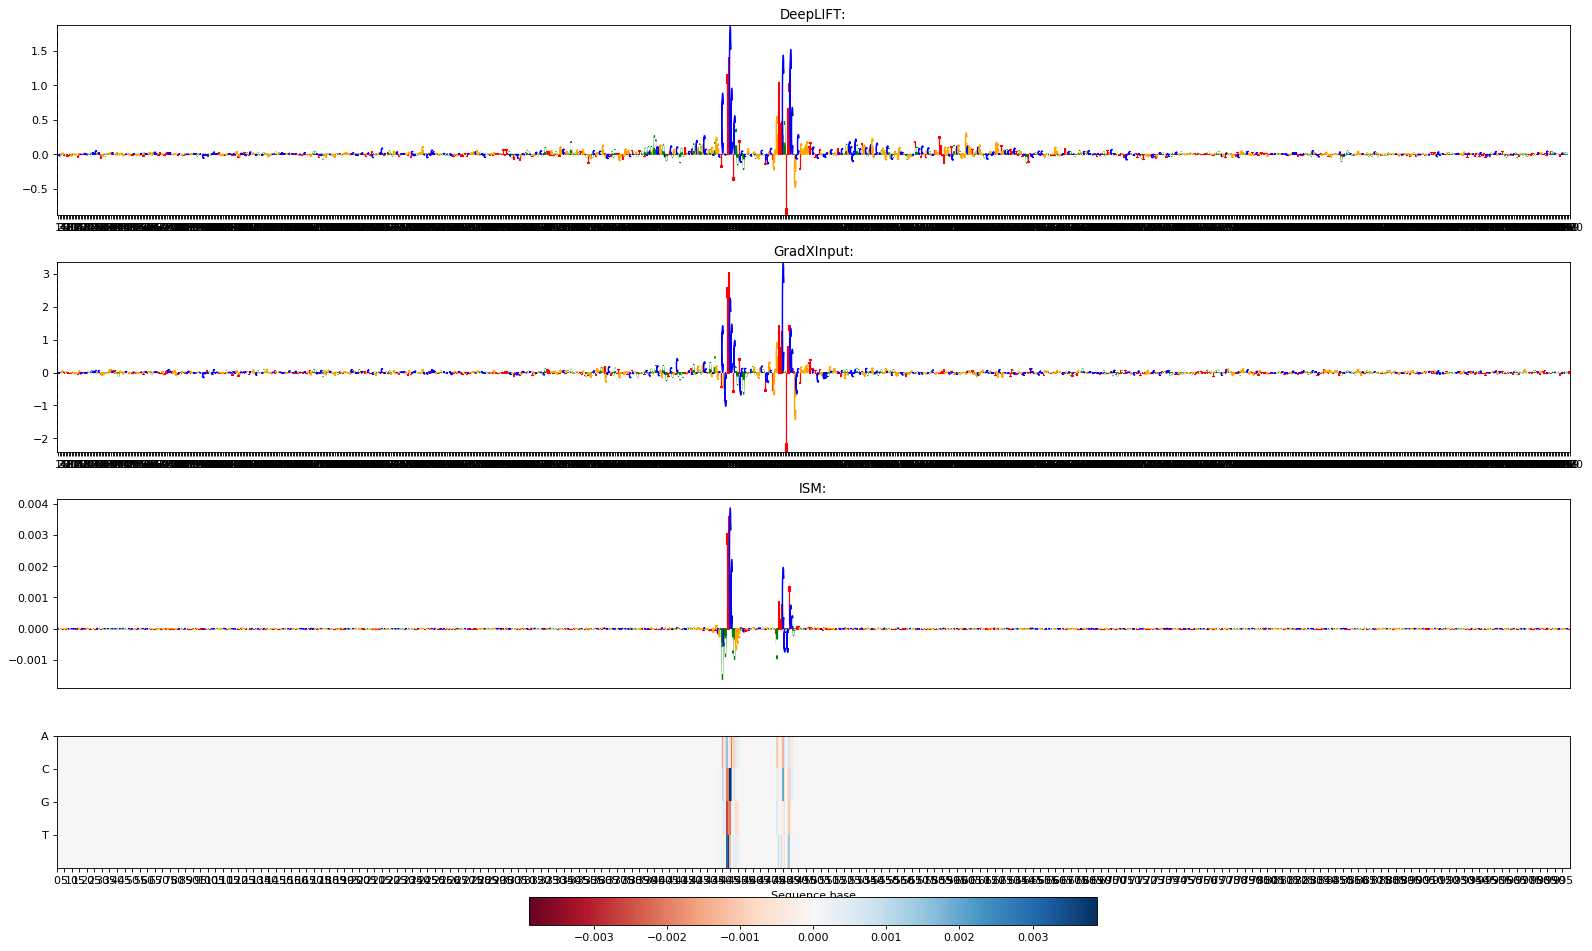

In [170]:
from dragonn.interpret import * 

pos_interpretations=multi_method_interpret(spi1_classification_model,
                                           example0,
                                           0,
                                           deeplift_score_func_classification)

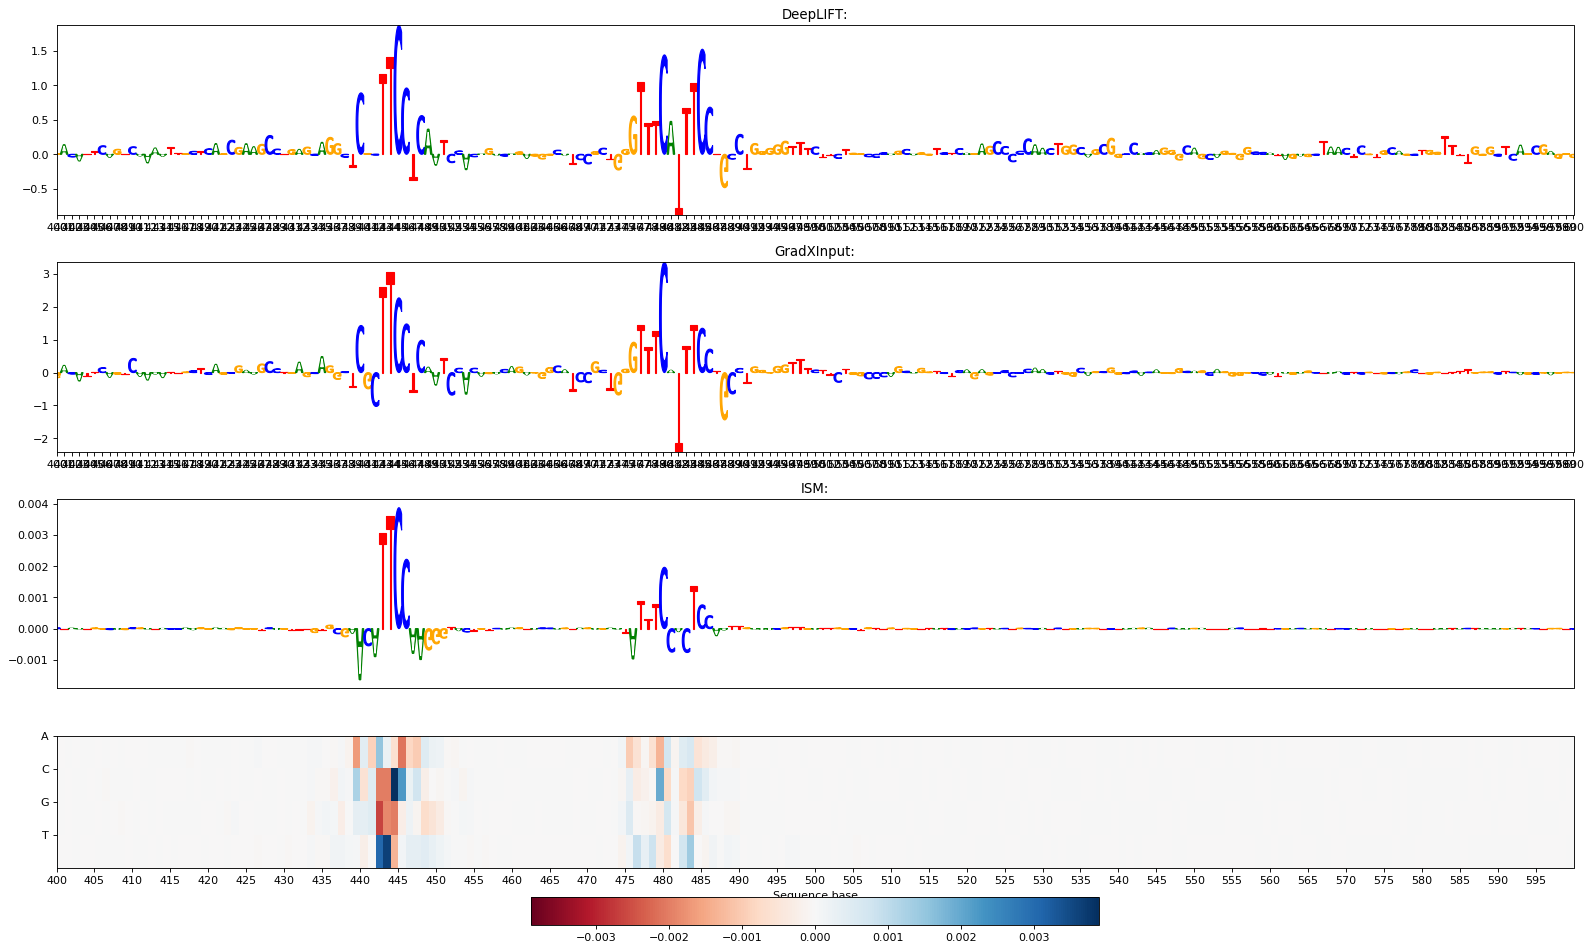

In [169]:
#let's zoom in to the central 200 bp 
from dragonn.vis import * 
plot_all_interpretations([pos_interpretations],example0,xlim=(400,600))

If we query the sequence "CACTTCCCCT" in the [TomTom](http://meme-suite.org/tools/tomtom) software from the MEME suite, we find that the motif is a good match for SPIB: 
<img src="https://github.com/kundajelab/dragonn/blob/master/tutorials/tutorial_images/SPI1.Tut4.png?raw=1" alt="SPI12TomTom" width="400"/>


#### Example 1 

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


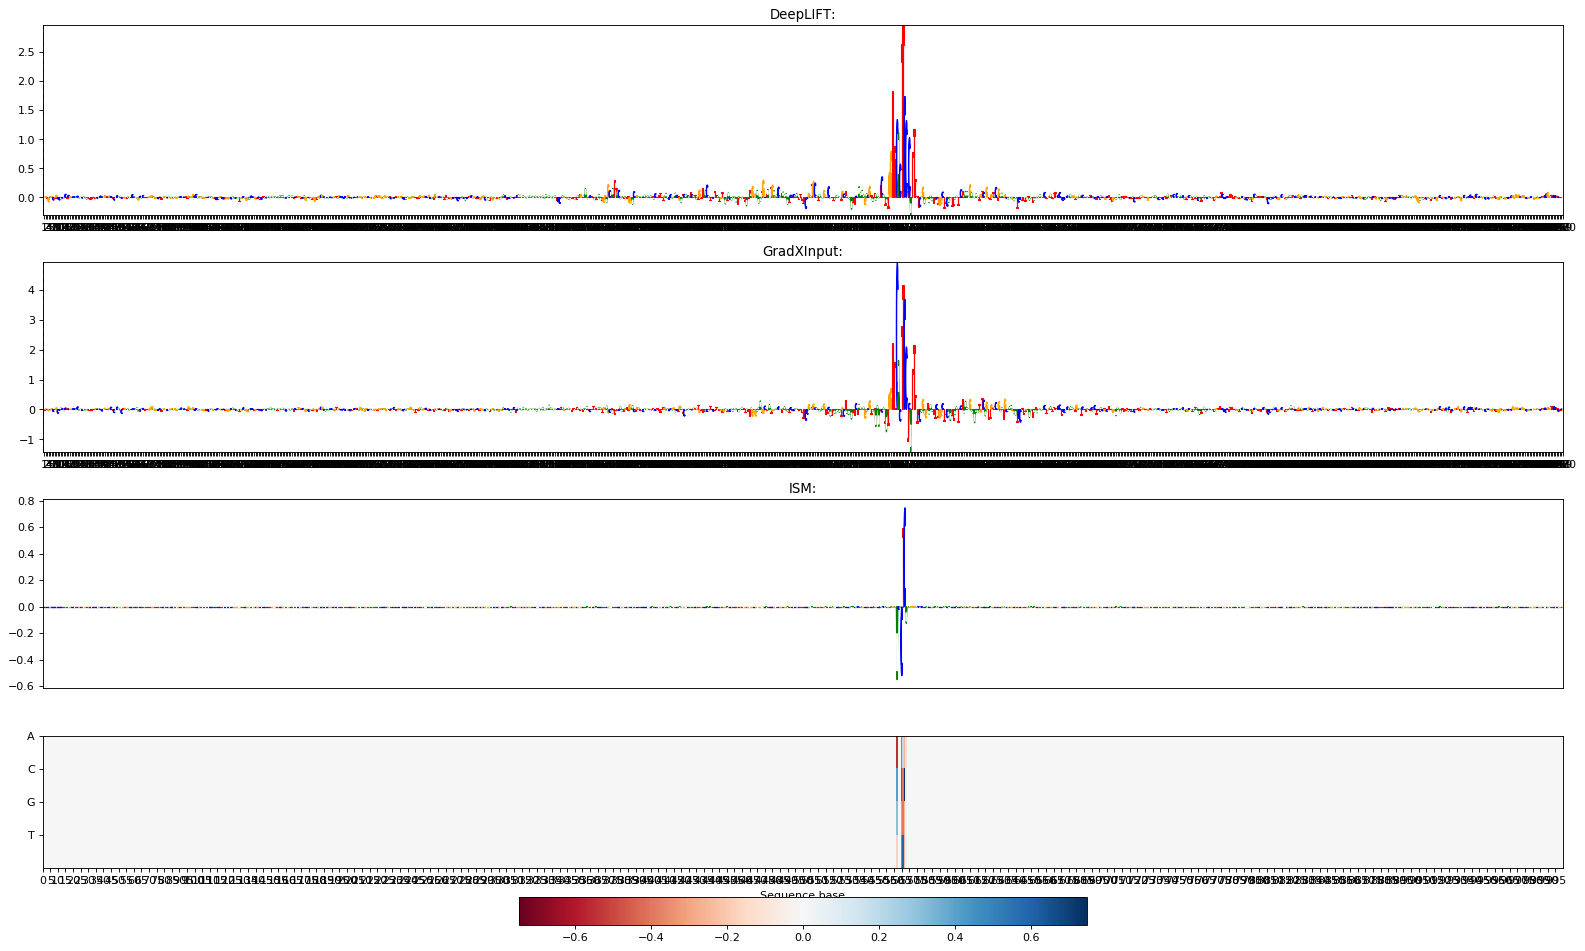

In [956]:
pos_interpretations=multi_method_interpret(spi1_classification_model,
                                           example1,
                                           0,
                                           deeplift_score_func_classification)

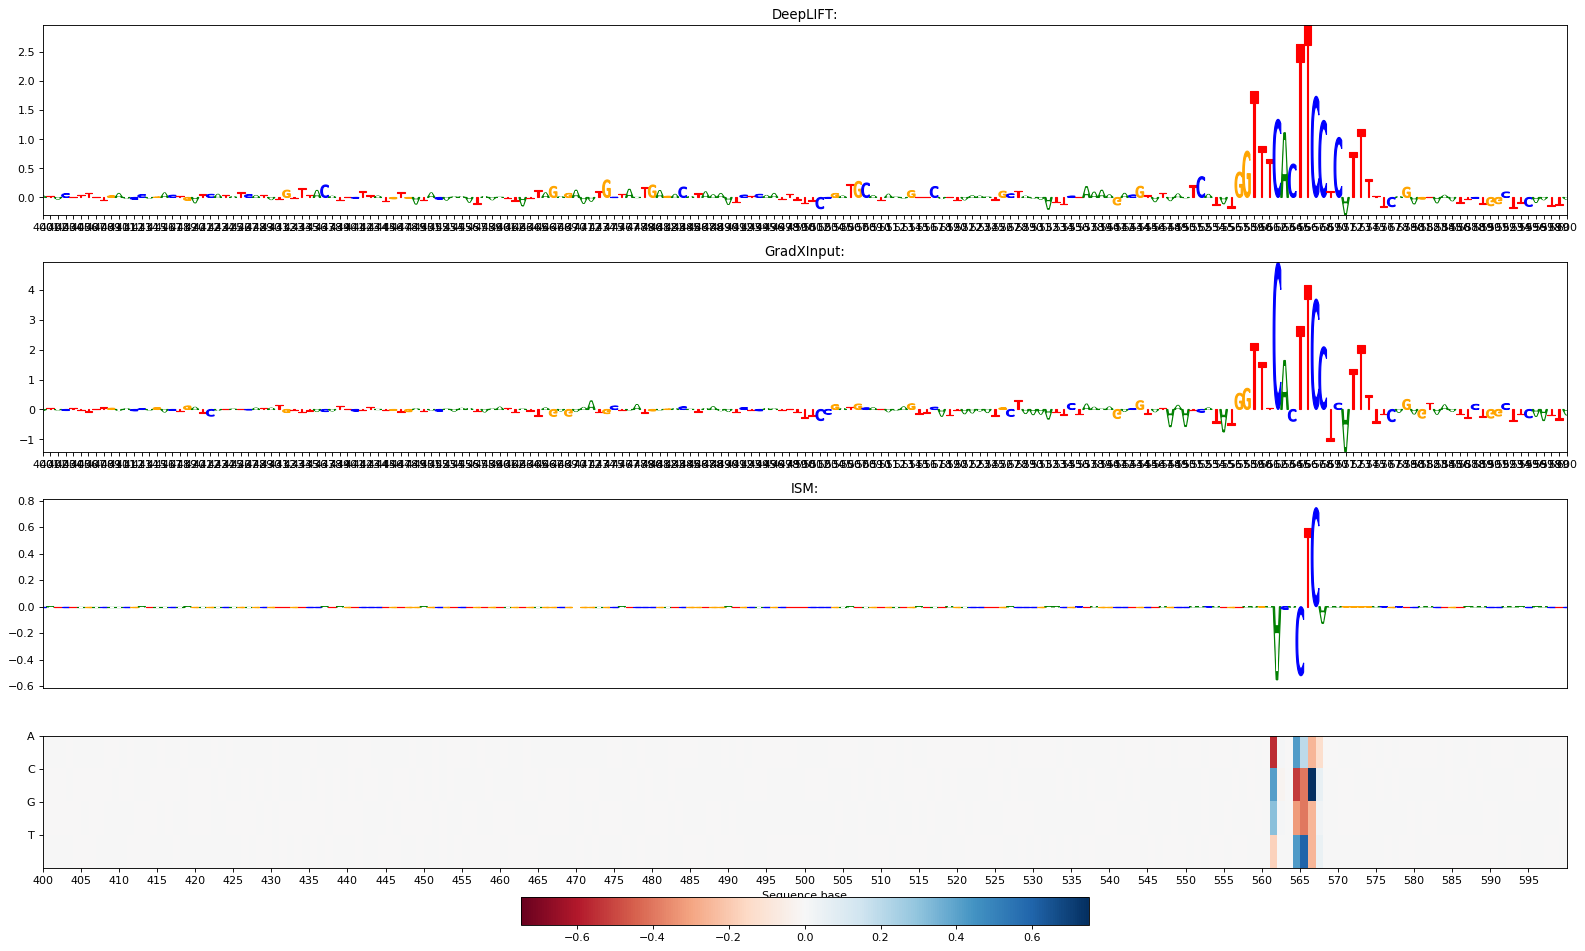

In [173]:
plot_all_interpretations([pos_interpretations],example1,xlim=(400,600))

#### Example 2 

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


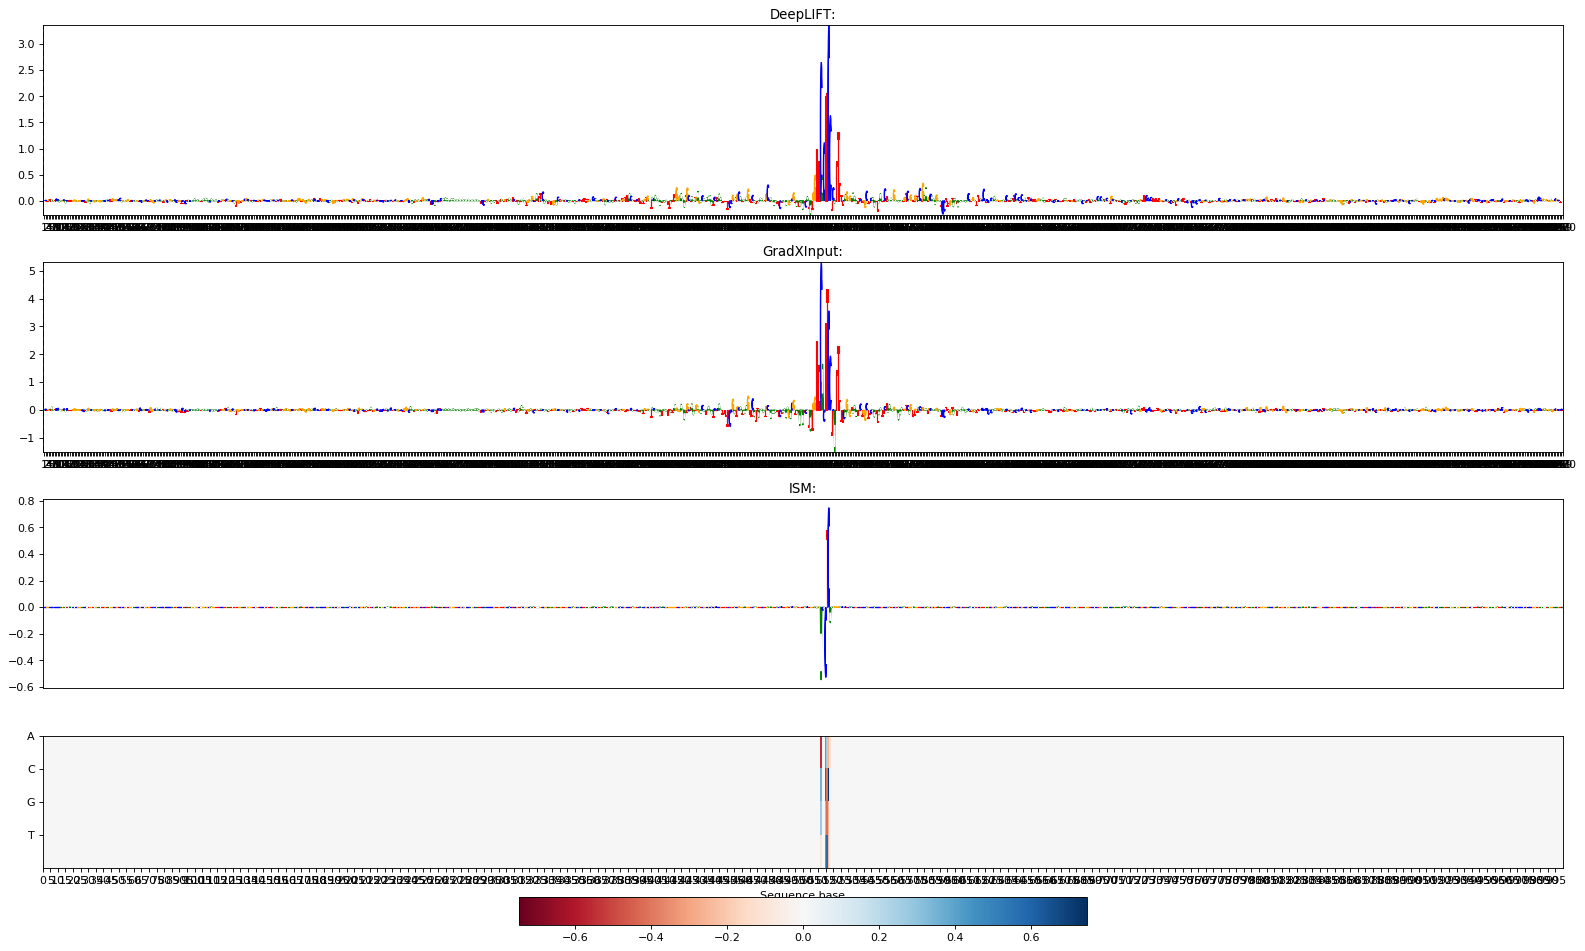

In [174]:
pos_interpretations=multi_method_interpret(spi1_classification_model,
                                           example2,
                                           0,
                                           deeplift_score_func_classification)

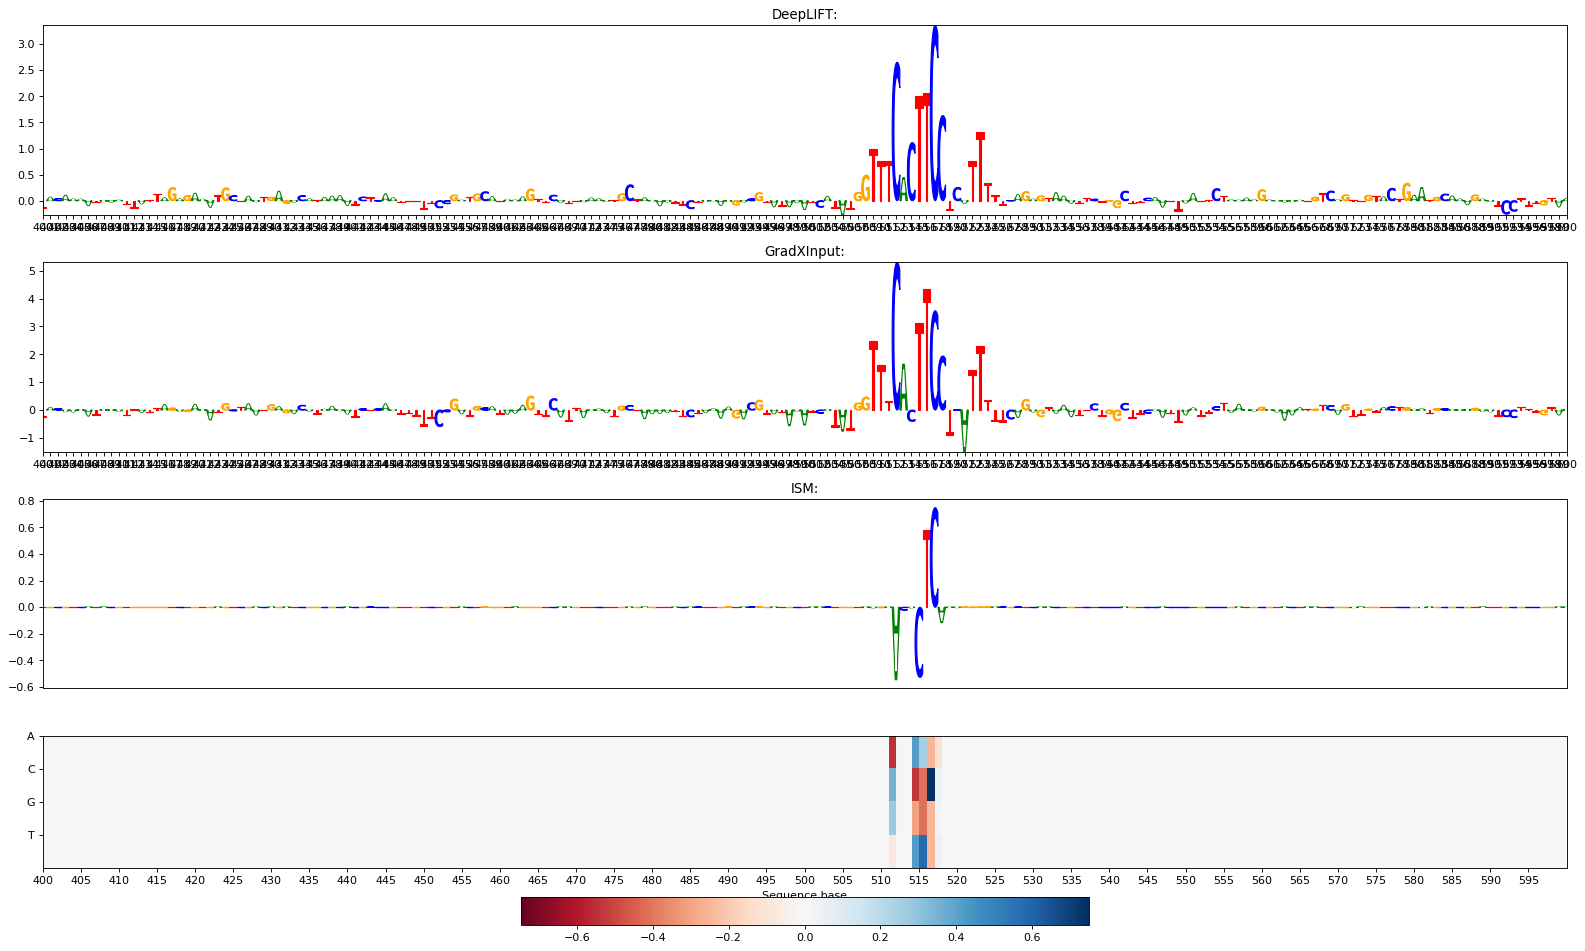

In [175]:
plot_all_interpretations([pos_interpretations],example2,xlim=(400,600))

In all three cases, the DeepLIFT motifs are strong matches for SPI1. 

### Regression model 

In [180]:
#Sanity-check that the model is learning the SPI1 motif by running DeepLIFT on True Positives with high confidence 
#get the true positive predictions 
true_pos_regression=spi1_test_regression_labels[(spi1_test_regression_labels.values*spi1_test_regression_calibrated_predictions)>4]
true_pos_regression.shape

(3756, 1)

In [183]:
interpretation_input_regression_spi1=one_hot_from_bed([i for i in true_pos.index],"hg19.genome.fa.gz")
interpretation_input_regression_spi1.shape

(3756, 1, 1000, 4)

In [184]:
example3= np.expand_dims(interpretation_input_regression_spi1[0],axis=1)
example4= np.expand_dims(interpretation_input_regression_spi1[1],axis=1)
example5= np.expand_dims(interpretation_input_regression_spi1[2],axis=1)


In [617]:
#get the deeplift scoring function for regression
deeplift_score_func_regression=get_deeplift_scoring_function("SPI1.regression.model.hdf5",target_layer_idx=-1)

#### Example 3 

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


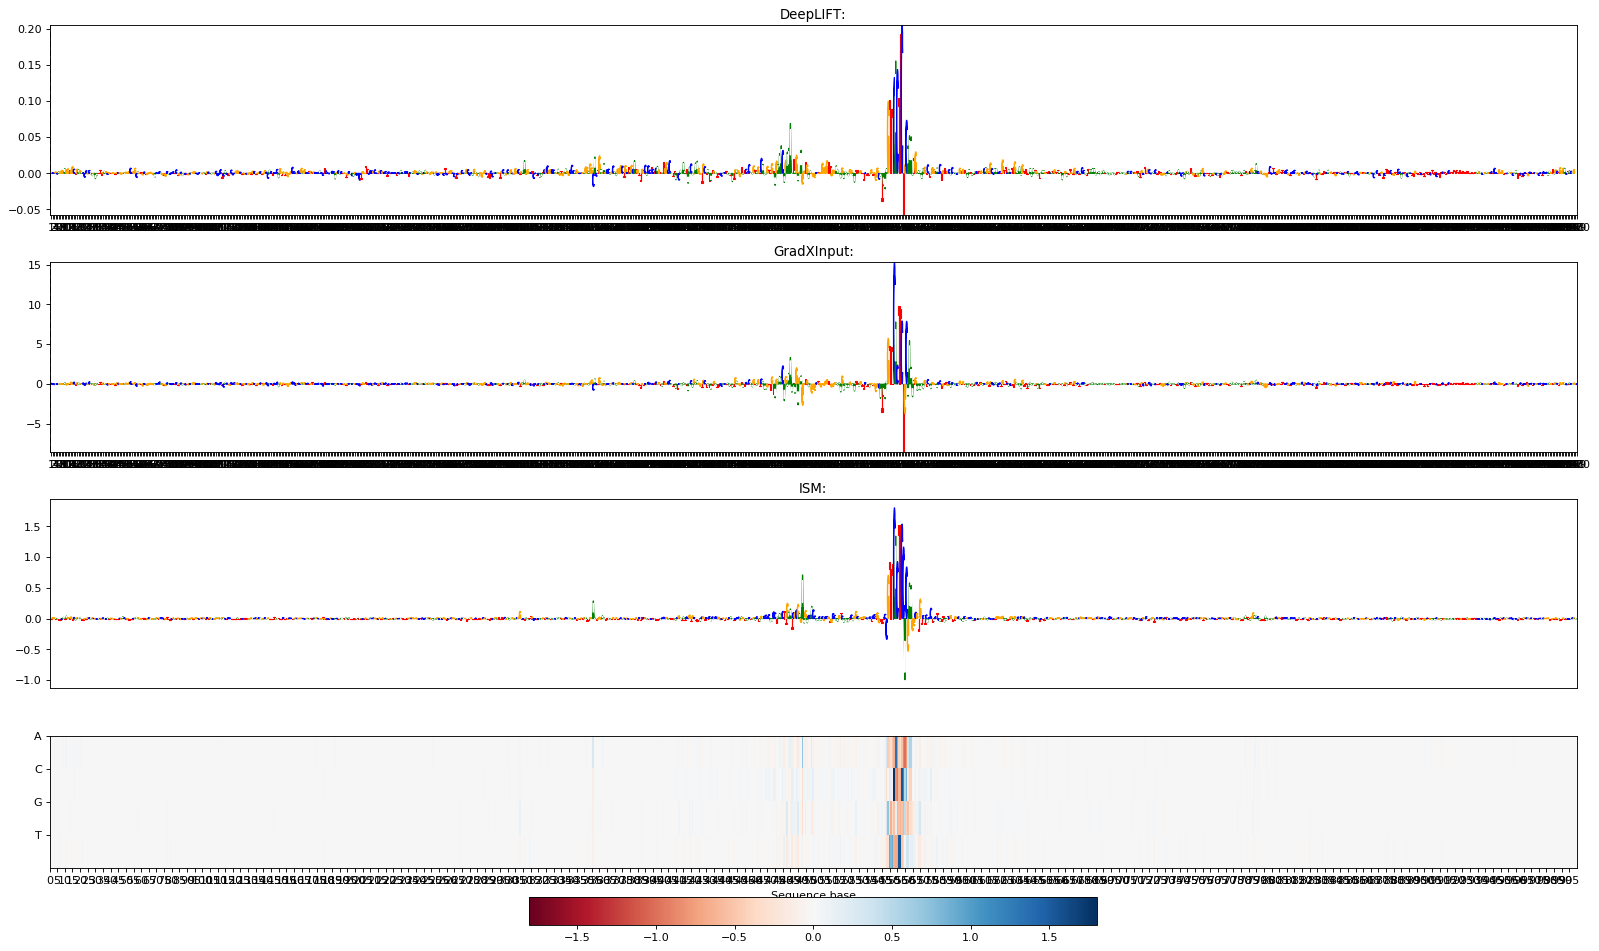

In [187]:
pos_interpretations=multi_method_interpret(spi1_regression_model,
                                           example3,
                                           0,
                                           deeplift_score_func_regression)

In [ ]:
plot_all_interpretations([pos_interpretations],example3,xlim=(500,700))

#### Example 4 

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


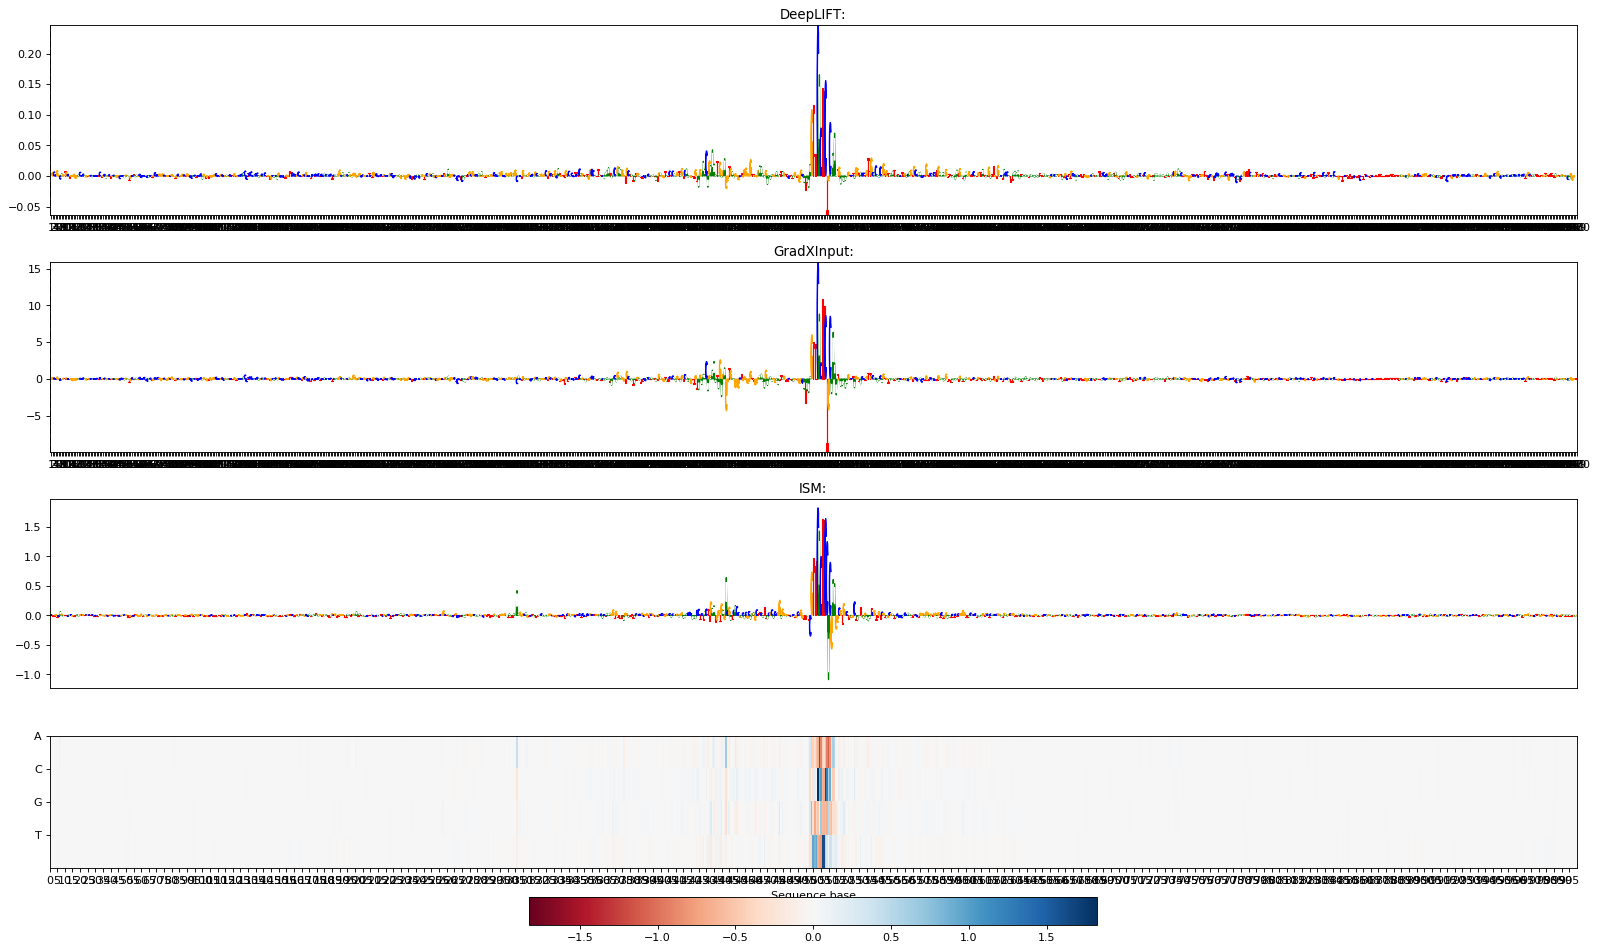

In [189]:
pos_interpretations=multi_method_interpret(spi1_regression_model,
                                           example4,
                                           0,
                                           deeplift_score_func_regression)

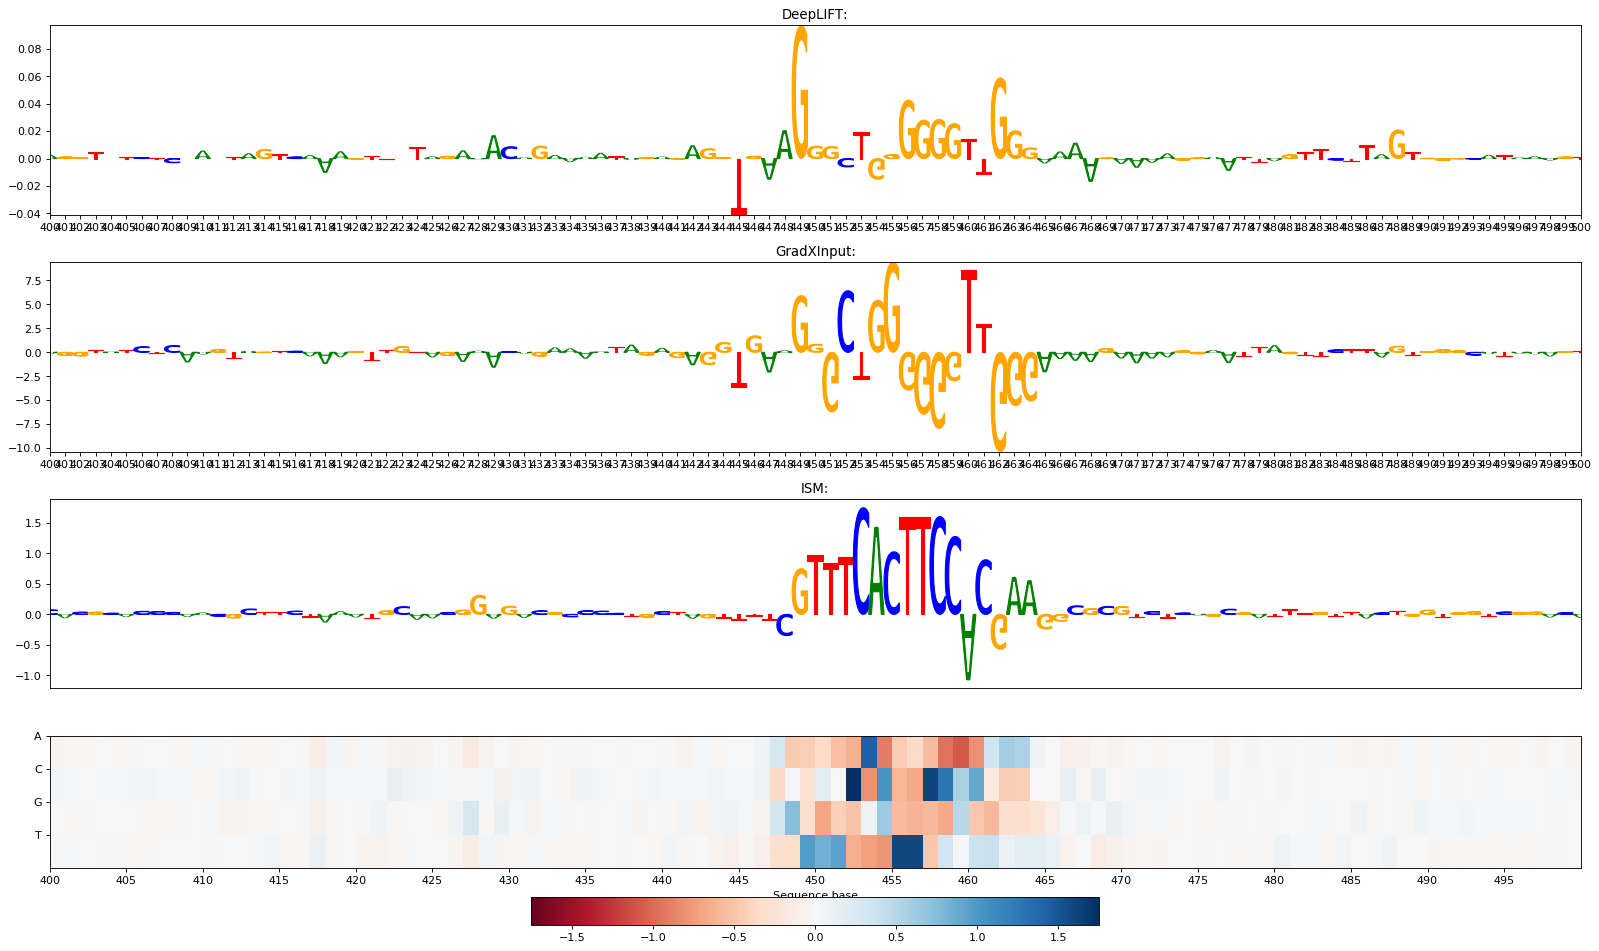

In [590]:
plot_all_interpretations([pos_interpretations],example4,xlim=(400,500))

#### Example 5 

getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


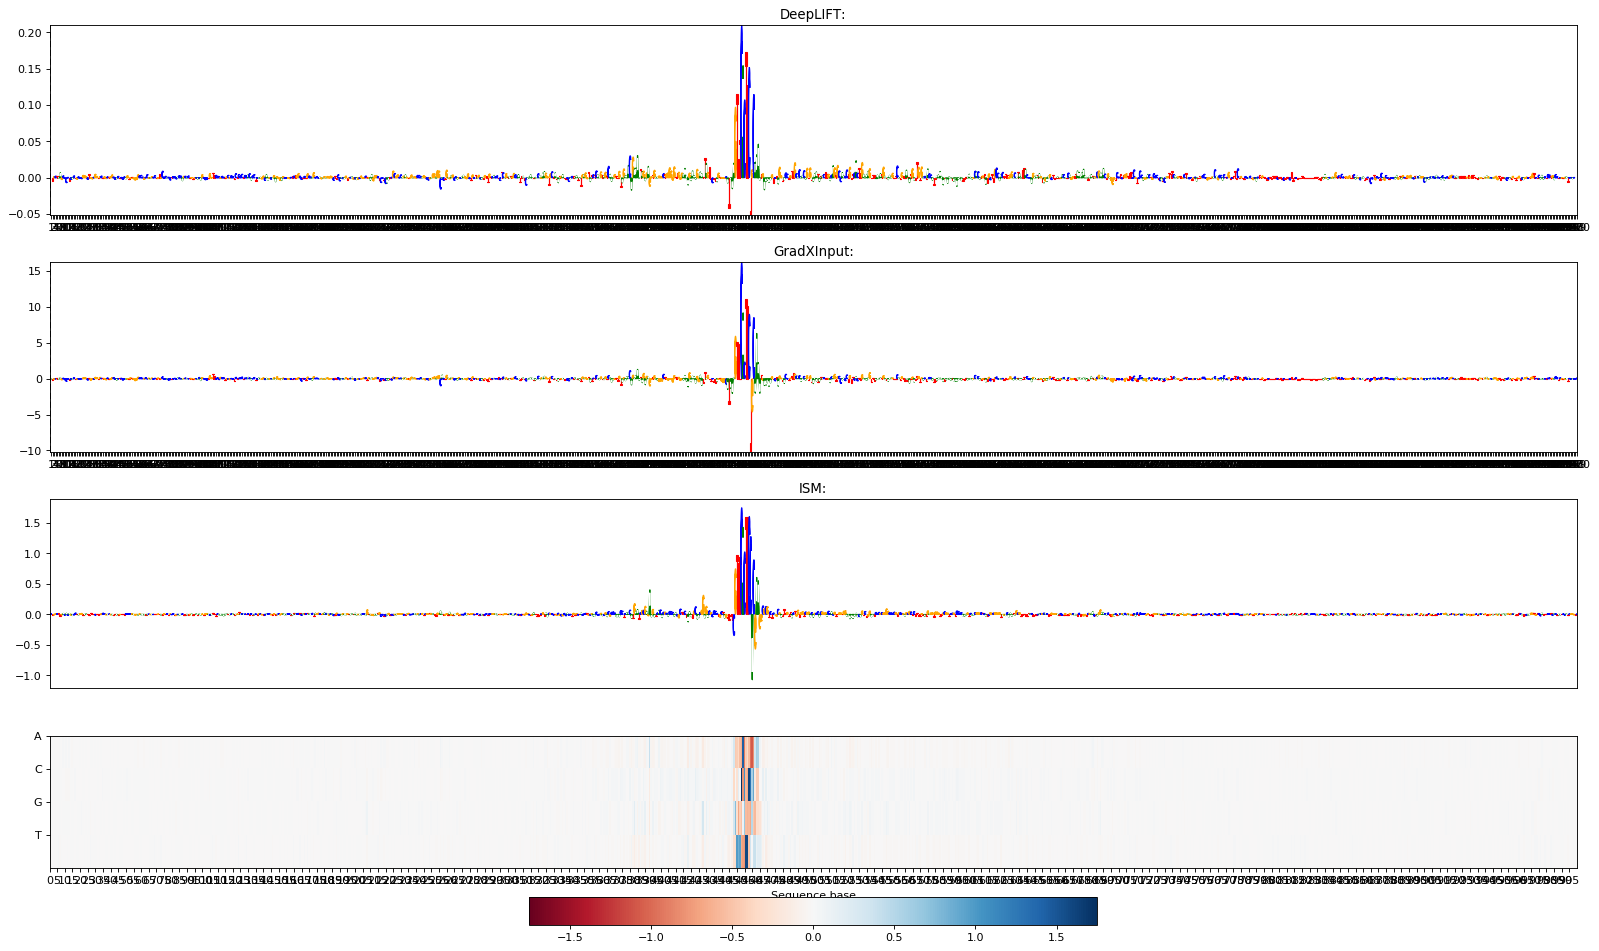

In [191]:
pos_interpretations=multi_method_interpret(spi1_regression_model,
                                           example5,
                                           0,
                                           deeplift_score_func_regression)

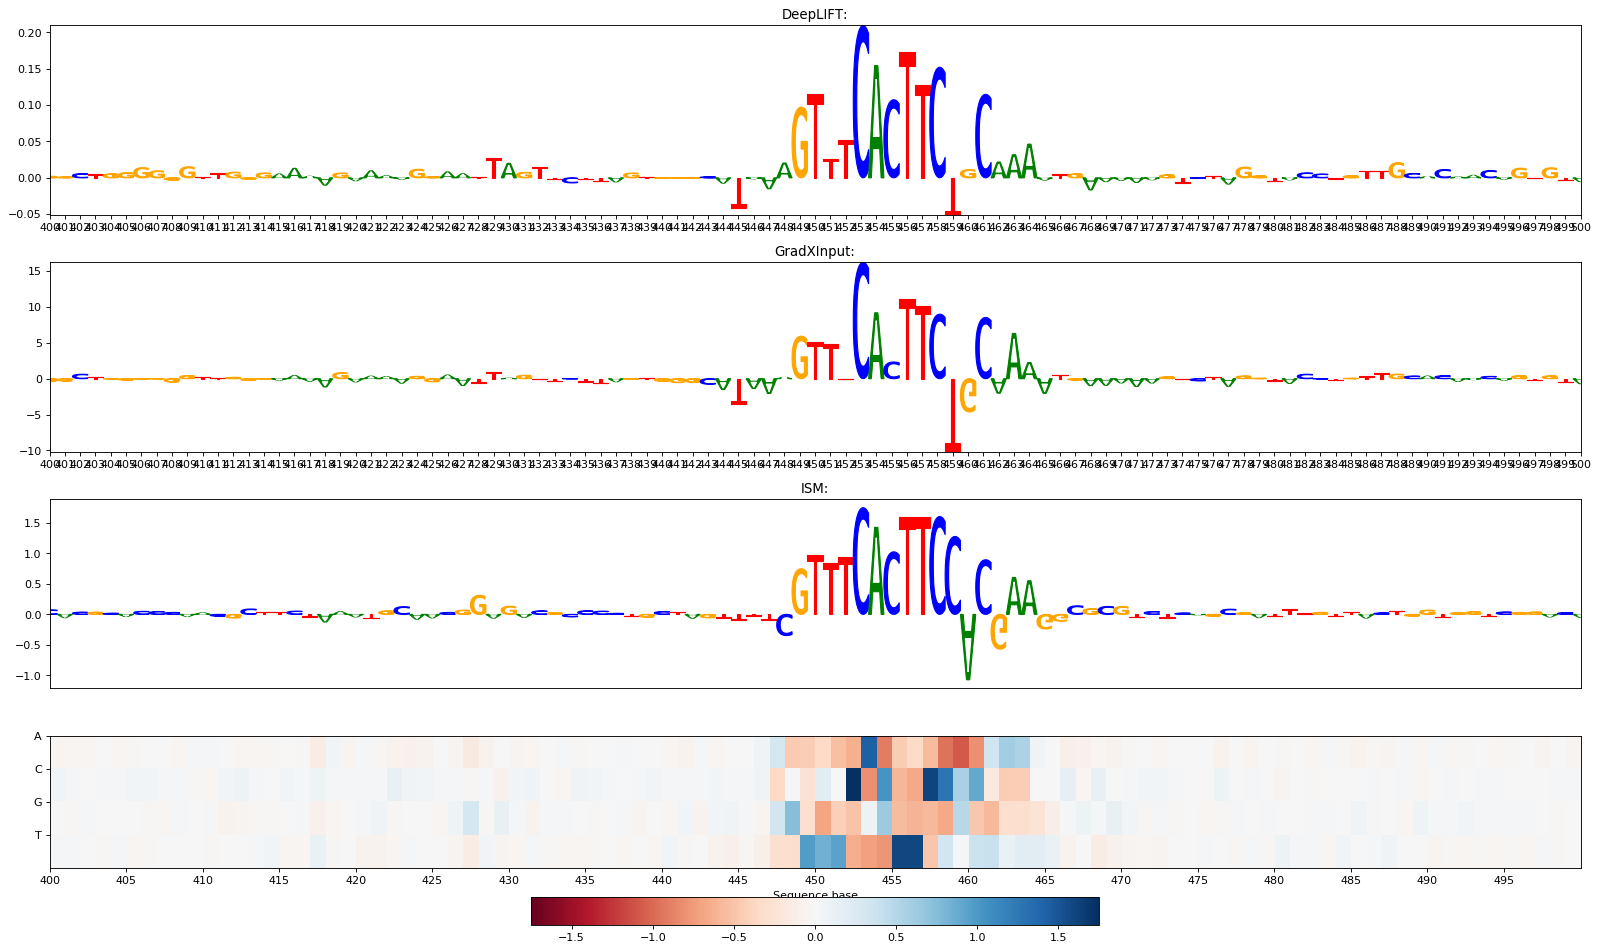

In [588]:
plot_all_interpretations([pos_interpretations],example5,xlim=(400,500))

The motif learned by the regression model matches the canonical SPI1 motif as well. 


## SPI1 bQTL Data <a name='10'>
    
<a href=#outline>Home</a>

A study by Fraser et al (https://www.cell.com/fulltext/S0092-8674(16)30339-7) identified several thousand cis-acting bQTL's that affect the binding of SPI1 transcription factors in humans. We examine how effective our models are at recognizing these bQTLs. 

### Read in and annotate the bQTL dataset <a name='a'>
<a href=#outline>Home</a>


In [240]:
## Download the bQTL dataset 
#!wget SPI1.bQTLs.txt.gz

In [241]:
#Read in the bQTL dataframe
bqtls=pd.read_csv("SPI1.bQTLs.txt.gz",header=0,sep='\t')
bqtls.head

<bound method NDFrame.head of           Chr   position  Depth  ALTdepth  REFDepth ALTallele POSTallele  \
0       chr17   18967176    538       418       120         G          A   
1        chr4  176935913    626       597        29         A          C   
2        chr1  144534083    618       368       250         T          C   
3       chr17   19015381    144       143         1         A          T   
4        chr1   17231724   2477      1321      1156         G          A   
5       chr16   87705494    115       105        10         G          C   
6       chr12   16789835    483        75       408         T          C   
7        chr6    4154143    361       341        20         G          A   
8       chr15   70174409    264       226        38         T          C   
9       chr12    8608502    443        16       427         A          T   
10       chr5  124341259    433       406        27         A          T   
11       chr7   31728180    533         6       527       

In [242]:
#Calculate the number of bQTL's
print(bqtls.shape)
n_bqtls=bqtls.shape[0]

(999799, 10)


In [243]:
#sort the bqtl's by p-value 
bqtls=bqtls.sort_values(by=['pvalue'])

We now annotate the bQTL's with the false discovery rate, the mean fold change bigWig signal in the bQTL region, and the logratio fo the post-CHIP frequency relative to the pre-CHIP frequency. 

In [244]:
#Calculate the Benjamini-Hochberg FDR 
bqtls['FDR']=1.0
for index,row in bqtls.iterrows(): 
    row['FDR']=min(row['FDR'],row['pvalue']*n_bqtls/(index+1))

In [245]:
# Calculate logratio of the Post-CHIP frequency to the pre-CHIP frequency
bqtls['logratio']=np.log((bqtls['POSTfreq']+.01)/(bqtls['prechipfreq']+0.01))

In [246]:
# IMPORTANT! Convert the bQTL coordinates from 1-indexing to 0-indexing
bqtls['start']=bqtls['position']-1
bqtls['end']=bqtls['position']

In [248]:
# Calculate the mean fold change bigWig signal within the 200 bp region 
# centered on the bQTL

#initialize the field within the Pandas dataframe with default value of 0
bqtls['mean_chipseq_fc']=0

#use the pyBigWig library to calculate the mean fold change bigWig signal 
#within the 200 bp region centered at the bQTL 
import pyBigWig 
bigwig_fh = pyBigWig.open("SPI1.pooled.fc.bigWig")
for index,row in bqtls.iterrows():
    values = bigwig_fh.values(row['Chr'],
                              row['end']-100,
                              row['end']+100,
                              numpy=True)
    row['mean_chipseq_fc'] = np.mean(values)
    if (index%1000 == 0):
        print("Done",index)


Done 0
Done 1000
Done 2000
Done 3000
Done 4000
Done 5000
Done 6000
Done 7000
Done 8000
Done 9000
Done 10000
Done 11000
Done 12000
Done 13000
Done 14000
Done 15000
Done 16000
Done 17000
Done 18000
Done 19000
Done 20000
Done 21000
Done 22000
Done 23000
Done 24000
Done 25000
Done 26000
Done 27000
Done 28000
Done 29000
Done 30000
Done 31000
Done 32000
Done 33000
Done 34000
Done 35000
Done 36000
Done 37000
Done 38000
Done 39000
Done 40000
Done 41000
Done 42000
Done 43000
Done 44000
Done 45000
Done 46000
Done 47000
Done 48000
Done 49000
Done 50000
Done 51000
Done 52000
Done 53000
Done 54000
Done 55000
Done 56000
Done 57000
Done 58000
Done 59000
Done 60000
Done 61000
Done 62000
Done 63000
Done 64000
Done 65000
Done 66000
Done 67000
Done 68000
Done 69000
Done 70000
Done 71000
Done 72000
Done 73000
Done 74000
Done 75000
Done 76000
Done 77000
Done 78000
Done 79000
Done 80000
Done 81000
Done 82000
Done 83000
Done 84000
Done 85000
Done 86000
Done 87000
Done 88000
Done 89000
Done 90000
Done 91000
D

Done 693000
Done 694000
Done 695000
Done 696000
Done 697000
Done 698000
Done 699000
Done 700000
Done 701000
Done 702000
Done 703000
Done 704000
Done 705000
Done 706000
Done 707000
Done 708000
Done 709000
Done 710000
Done 711000
Done 712000
Done 713000
Done 714000
Done 715000
Done 716000
Done 717000
Done 718000
Done 719000
Done 720000
Done 721000
Done 722000
Done 723000
Done 724000
Done 725000
Done 726000
Done 727000
Done 728000
Done 729000
Done 730000
Done 731000
Done 732000
Done 733000
Done 734000
Done 735000
Done 736000
Done 737000
Done 738000
Done 739000
Done 740000
Done 741000
Done 742000
Done 743000
Done 744000
Done 745000
Done 746000
Done 747000
Done 748000
Done 749000
Done 750000
Done 751000
Done 752000
Done 753000
Done 754000
Done 755000
Done 756000
Done 757000
Done 758000
Done 759000
Done 760000
Done 761000
Done 762000
Done 763000
Done 764000
Done 765000
Done 766000
Done 767000
Done 768000
Done 769000
Done 770000
Done 771000
Done 772000
Done 773000
Done 774000
Done 775000
Done

### DNN predictions for Post and Alt alleles within the bQTL dataset  <a name='b'>
<a href=#outline>Home</a>

We would like to obtain calibrated predictions for the reference and alternate alleles at each bQTL. Consequently, we first obtain the logits (for the classification model) and pre-activations (for the regression model) and then run these through the calibration functions, as define above. 


In [249]:
# get model predictions for bQTLs 
from dragonn.generators import * 
bqtl_post_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","POSTallele")
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","ALTallele")

In [250]:
bqtl_post_classification_logits=classification_preact_model.predict_generator(bqtl_post_gen,
                                                                          max_queue_size=5000,
                                                                          workers=40,
                                                                          use_multiprocessing=True,
                                                                          verbose=1)


7811/7811 [==============================] - 109s 14ms/step


In [251]:
#get the calibrated predictions 
bqtl_post_classification_predictions=get_calibrated_predictions(bqtl_post_classification_logits,
                                                                           classification_calibration_funcs)

(999799, 1)


In [252]:
bqtl_alt_classification_logits=classification_preact_model.predict_generator(bqtl_alt_gen,
                                                               max_queue_size=5000, 
                                                               workers=40, 
                                                               use_multiprocessing=True, 
                                                               verbose=1)

#get the calibrated predictions 
bqtl_alt_classification_predictions=get_calibrated_predictions(bqtl_alt_classification_logits,
                                                                classification_calibration_funcs)
bqtl_post_classification_truth=bqtl_post_gen.data['pvalue']
#bqtl_post_classification_truth=np.expand_dims(bqtl_post_classification_truth,axis=1)

7811/7811 [==============================] - 114s 15ms/step
(999799, 1)


In [253]:
# re-initialize the generators for use in obtaining 
#predictions from regression models. 
bqtl_post_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","POSTallele")
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.txt.gz","hg19.genome.fa.gz","ALTallele")

In [254]:
bqtl_post_regression_preacts=regression_preact_model.predict_generator(bqtl_post_gen,
                                                                          max_queue_size=5000,
                                                                          workers=40,
                                                                          use_multiprocessing=True,
                                                                          verbose=1)
#get the calibrated predictions 
bqtl_post_regression_predictions=get_calibrated_predictions(bqtl_post_regression_preacts,
                                                                           regression_calibration_funcs)

7811/7811 [==============================] - 110s 14ms/step
(999799, 1)


In [255]:
bqtl_alt_regression_preacts=regression_preact_model.predict_generator(bqtl_alt_gen,
                                                                          max_queue_size=5000,
                                                                          workers=40,
                                                                          use_multiprocessing=True,
                                                                          verbose=1)
#get the calibrated predictions 
bqtl_alt_regression_predictions=get_calibrated_predictions(bqtl_alt_regression_preacts,
                                                           regression_calibration_funcs)

7811/7811 [==============================] - 105s 13ms/step
(999799, 1)


Let's augment the bQTL dataframe with the model predictions. Let's summarize the predictions we have generated on the bQTL dataset: 

* Classification model logits for the POST allele 
* Classification model calibrated predictions for the POST allele 
* Classification model logits for the ALT allele 
* Classification model calibrated predictions for the ALT allele 



* Regression model pre-activations for the POST allele 
* Regression model calibrated predictions for the POST allele 
* Regression model pre-activations for the ALT allele 
* Regression model calibrated predictions for the ALT allele 



In [257]:
bqtls['post_classification_logits']=bqtl_post_classification_logits
bqtls['post_classification_predictions']=bqtl_post_classification_predictions 

bqtls['alt_classification_logits']=bqtl_alt_classification_logits
bqtls['alt_classification_predictions']=bqtl_alt_classification_predictions 

bqtls['post_regression_preacts']=bqtl_post_regression_preacts
bqtls['post_regression_predictions']=bqtl_post_regression_predictions 

bqtls['alt_regression_preacts']=bqtl_alt_regression_preacts
bqtls['alt_regression_predictions']=bqtl_alt_regression_predictions 



In [258]:
#Let's save the augmented bQTL data frame so we can resume from 
# this point in the analysis more easily. 
bqtls.to_csv("SPI1.bQTLs.augmented.txt.gz",
            sep='\t',
            header=True,
            index=False,
            compression='gzip')

## Compare model predictions on POST and ALT alleles  <a name='c'>
<a href=#outline>Home</a>


We now assess whether the model predictions of accessibility change for significant bQTL's when the reference allele is replaced with the alternate allele in the input sequence. We also compare the distribution of reference vs alternate predictions for the set of significant bQTLS to the corresponding distribution for the set of non-significant bQTLs. 

First, we must select comparable subsets of non-significant and significant bQTLs from the bQTL dataset. For our purposes, the sets are comparable if they have similar distributions of accessibility predictions, where predictions are defined as the max of the reference and alternate allele predictions. To ensure that we are comparing such "matched" subsets, we perform the following steps:  

In [266]:
#We define a temporary field in the bqtl dataframe to store the maximum 
# of the calibrated classification predictions for the alternate and reference 
# alleles 
bqtls['max_classification_predictions']=bqtls[["post_classification_predictions",
                                               "alt_classification_predictions"]].max(axis=1)

#We define another temporary field to store the maximum of the 
# calibrated regression predictions for the alternate and reference alleles 
bqtls['max_regression_predictions']=bqtls[['post_regression_predictions',
                                          'alt_regression_predictions']].max(axis=1)


In [267]:
significant_bqtls=bqtls[bqtls['pvalue']<=5e-5]
non_significant_bqtls=bqtls[bqtls['pvalue']==1]


In [268]:
significant_bqtls.shape

(3831, 25)

In [269]:
non_significant_bqtls.shape

(198884, 25)

We define a helper function to sample bQTLS from the bQTL dataset to match another subset of bQTLS according to a user-specified attr_name. This function will allow us to compare the accessibility predictions for significant bQTLS with the non-significant bQTLS. 

In [299]:
def plot_distribution(bqtls_to_match,matched_sampled_bqtls,attr_name):
    toplot=pd.DataFrame({"bqtls_to_match":bqtls_to_match[attr_name],
                        "matched_sampled_bqtls":matched_sampled_bqtls[attr_name]})
    toplot=toplot.melt()
    print((ggplot(toplot,aes(x="value",group="variable",color="variable",fill="variable"))
     +geom_density(alpha=0.3)
     +theme_bw()
     +xlab(attr_name)
     +ylab("Density")))

    print((ggplot(bqtls_to_match,aes(x=attr_name))
     +geom_density(alpha=0.3)
     +theme_bw()
     +xlab(attr_name)
     +ylab("Density")
     +ggtitle("bqtls_to_match")))

    print((ggplot(matched_sampled_bqtls,aes(x=attr_name))
     +geom_density(alpha=0.3)
     +theme_bw()
     +xlab(attr_name)
     +ylab("Density")
     +ggtitle("matched_sampled_bqtls")))



def sample_matched_bqtls(bqtls_to_match, bqtls_to_sample, attr_name):
    #sort bqtls_to_sample by attr_name
    sorted_bqtls_to_sample=bqtls_to_sample.sort_values(by=[attr_name])
    sorted_bqtls_to_sample_vals = sorted_bqtls_to_sample[attr_name]
    
    bqtls_to_match_vals = bqtls_to_match[attr_name]
    
    #find indices in the bqtls_to_match_vals Series that are close in value to corresponding entries 
    # from sorted_bqtls_to_sample_vals
    searchsorted_indices = np.searchsorted(a=np.array(sorted_bqtls_to_sample_vals), 
                                           v=np.array(bqtls_to_match_vals))
    
    matched_sampled_bqtls_indices = set()
    
    for idx in searchsorted_indices:
        #shift the index until you find one that isn't taken
        shift = 1
        while (idx in matched_sampled_bqtls_indices or idx==len(sorted_bqtls_to_sample)):
            if idx == len(sorted_bqtls_to_sample):
                shift = -1
            idx += shift
        if (idx < 0 or idx > len(sorted_bqtls_to_sample)):
            print(idx)
        matched_sampled_bqtls_indices.add(idx)
    
    matched_sampled_bqtls = sorted_bqtls_to_sample.iloc[list(matched_sampled_bqtls_indices)]
    
    plot_distribution(bqtls_to_match,matched_sampled_bqtls,attr_name)
        
    return matched_sampled_bqtls

We now utilize the "sample_matched_bqtls" helper function to select matched subsets of significant and non-significant bQTLs by model prediction values 

/users/annashch/miniconda3/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_density : Removed 7662 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


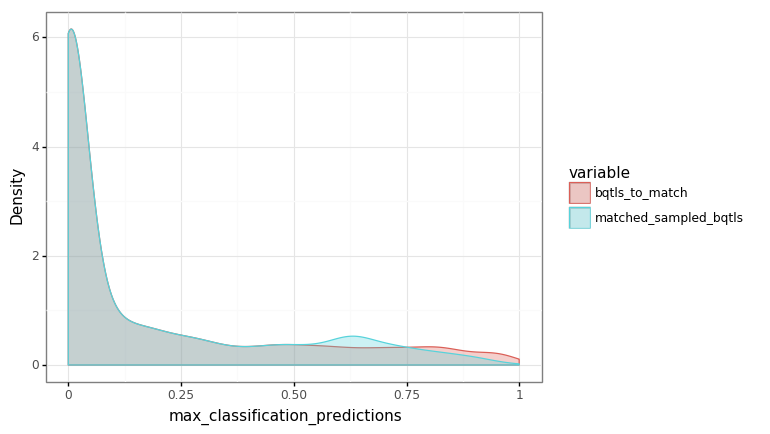

<ggplot: (8746760409699)>


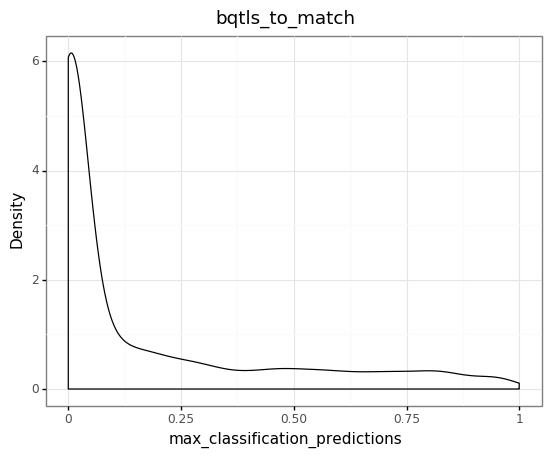

<ggplot: (8746751788040)>


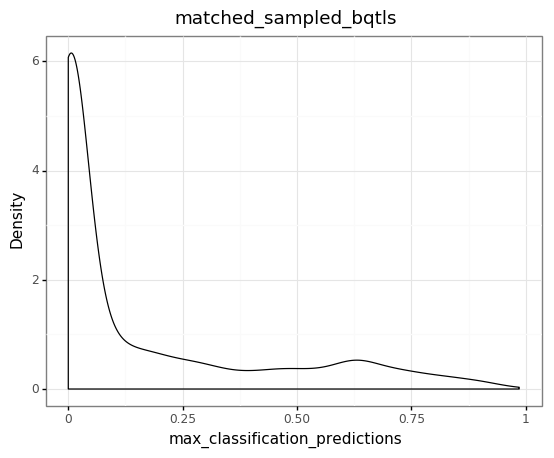

<ggplot: (8746758845865)>


In [300]:
matched_bqtls_maxaltpost = sample_matched_bqtls(bqtls_to_match=significant_bqtls,
                                                     bqtls_to_sample=non_significant_bqtls,
                                                     attr_name="max_classification_predictions")

We have now verified that the distribution of max(alt allele prediction, ref allele predictions) for the significant bQTL subset matches the corresponding distribution for the non-significant bQTL subset. 

Our next step is to generate a scatterplot examining the model predictions for reference vs alternate alleles within the matched significant and non-significant subsets: 

In [315]:
#concatenate the subset of significant bQTL's and the matched subset of non-significant bQTL's for visualization on the 
# same plotting axes 
significant_bqtls['Significant_bQTL']=True
matched_bqtls_maxaltpost['Significant_bQTL']=False 
to_score_bqtls=pd.concat([significant_bqtls,matched_bqtls_maxaltpost],axis=0)


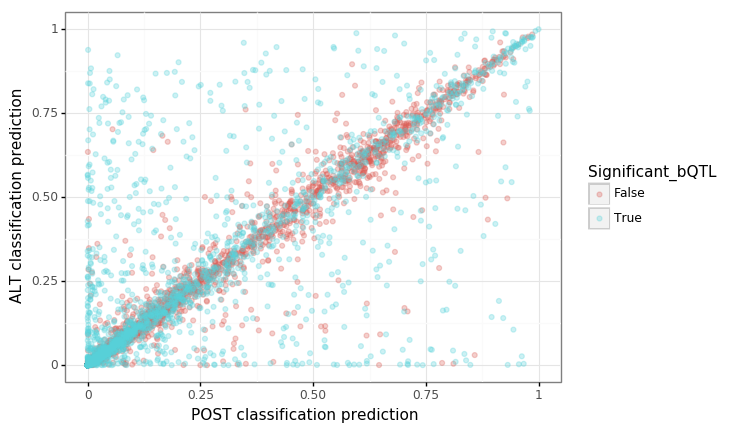

<ggplot: (8746755581034)>


In [316]:
#use the plotnine plotting library to generate a scatterplot of calibrated classification predictions 
# for the POST and ALT alleles within the significant and matched non-significant bQTL subsets. 
print((ggplot(to_score_bqtls,aes(x="post_classification_predictions",
                y="alt_classification_predictions",
                group="Significant_bQTL",
                color="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("POST classification prediction")
             +ylab("ALT classification prediction")
             +theme_bw()))


As expected, we observe a much higher fraction of significant bQTL's deviating from the diagonal of the plot relative to the non-significant bQTL's. This makes sense -- if a bQTL lies along the diagonal, then the model prediction for the POST allele is very close to the prediction for the ALT allele (i.e. the SNP does not have a strong effect on prediction of accessibility). However, when a bQTL lies far from the diagonal, the model predicts a different probability of chromatin accessibility for the POST and ALT alleles -- i.e. the SNP is disrupting TF binding. 

## bQTL dataset motif scan with HOCOMOCO SPI1 motif  <a name='d'>
<a href=#outline>Home</a>

Our next step is to annotate the to-score bQTLs with the fasta sequence around them and do motif scoring to determine whether the SPI1 motif is driving the change in model predictions for the reference and altenate alleles. 

In [709]:
#We save the "to_score" bQTL subset to an output file so we can reproduce this analysis in the future starting from the 
# motif scoring step. 
to_score_bqtls.to_csv("SPI1.bQTLs.toScore.txt.gz",
                      sep='\t',
                      index=False,
                      compression="gzip")
num_to_score=to_score_bqtls.shape[0]

In [710]:
#We use a flank size of 10 on either side of the bQTL 
flank_size=10

#Once again, we initialize our POST and ALT generators for the bQTL dataset, focusing only on the significant bQTLs and 
# our matched non-significant subset. 
#We use a hack where we set the batch size equal to the number of bQTL's to be scored so we get the one-hot-encoding 
#for all bQTL's simultaneously in one batch 
bqtl_post_gen=BQTLGenerator("SPI1.bQTLs.toScore.txt.gz",
                            "hg19.genome.fa.gz",
                            "POSTallele",
                            flank_size=flank_size,
                            batch_size=num_to_score)
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.toScore.txt.gz",
                           "hg19.genome.fa.gz",
                           "ALTallele",
                           flank_size=flank_size,
                           batch_size=num_to_score)



We now load the SPI1 count matrix from the [HOCOMOCO](http://hocomoco11.autosome.ru/motif/SPI1_HUMAN.H11MO.0.A) database. 

In [744]:
! [[ -e SPI1.pcm ]] || curl http://hocomoco11.autosome.ru/final_bundle/hocomoco11/full/HUMAN/mono/pcm/SPI1_HUMAN.H11MO.0.A.pcm > SPI1.pcm

/bin/sh: 1: [[: not found
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1143  100  1143    0     0   2961      0 --:--:-- --:--:-- --:--:--  2961


In [745]:
! cat SPI1.pcm

>SPI1_HUMAN.H11MO.0.A
212.00000000000003	102.00000000000001	127.00000000000001	59.00000000000001
246.00000000000003	50.00000000000001	165.00000000000003	39.00000000000001
343.00000000000006	22.000000000000004	84.00000000000001	51.00000000000001
386.00000000000006	14.000000000000002	63.00000000000001	37.00000000000001
326.00000000000006	7.000000000000001	59.00000000000001	108.00000000000001
74.00000000000001	34.00000000000001	377.00000000000006	15.000000000000002
361.00000000000006	24.000000000000004	112.00000000000001	3.000000000000001
29.000000000000004	0.0	471.00000000000006	0.0
1.0000000000000002	0.0	499.00000000000006	0.0
500.00000000000006	0.0	0.0	0.0
499.00000000000006	0.0	0.0	1.0000000000000002
18.000000000000004	85.00000000000001	397.00000000000006	0.0
34.00000000000001	26.000000000000004	20.000000000000004	420.00000000000006
21.000000000000004	61.00000000000001	408.00000000000006	10.000000000000002
227.00000000000003	61.00000000000001	166.00000000000003	46.00000000000001
180.0

In [751]:
spi1_pcm = np.array([
                [float(x) for x in row.rstrip().split("\t")]
                for (i,row) in enumerate(open("SPI1.pcm")) if i > 0]).transpose((1,0))


In [752]:
spi1_pcm

array([[212., 246., 343., 386., 326.,  74., 361.,  29.,   1., 500., 499.,
         18.,  34.,  21., 227., 180., 199.],
       [102.,  50.,  22.,  14.,   7.,  34.,  24.,   0.,   0.,   0.,   0.,
         85.,  26.,  61.,  61.,  91.,  65.],
       [127., 165.,  84.,  63.,  59., 377., 112., 471., 499.,   0.,   0.,
        397.,  20., 408., 166., 159., 129.],
       [ 59.,  39.,  51.,  37., 108.,  15.,   3.,   0.,   0.,   0.,   1.,
          0., 420.,  10.,  46.,  70., 107.]])

In [865]:
#add a pseudocount for motif normalization 
pseudocount=10e-4
spi1_pcm+=pseudocount
spi1_pcm

array([[2.12011e+02, 2.46011e+02, 3.43011e+02, 3.86011e+02, 3.26011e+02,
        7.40110e+01, 3.61011e+02, 2.90110e+01, 1.01100e+00, 5.00011e+02,
        4.99011e+02, 1.80110e+01, 3.40110e+01, 2.10110e+01, 2.27011e+02,
        1.80011e+02, 1.99011e+02],
       [1.02011e+02, 5.00110e+01, 2.20110e+01, 1.40110e+01, 7.01100e+00,
        3.40110e+01, 2.40110e+01, 1.10000e-02, 1.10000e-02, 1.10000e-02,
        1.10000e-02, 8.50110e+01, 2.60110e+01, 6.10110e+01, 6.10110e+01,
        9.10110e+01, 6.50110e+01],
       [1.27011e+02, 1.65011e+02, 8.40110e+01, 6.30110e+01, 5.90110e+01,
        3.77011e+02, 1.12011e+02, 4.71011e+02, 4.99011e+02, 1.10000e-02,
        1.10000e-02, 3.97011e+02, 2.00110e+01, 4.08011e+02, 1.66011e+02,
        1.59011e+02, 1.29011e+02],
       [5.90110e+01, 3.90110e+01, 5.10110e+01, 3.70110e+01, 1.08011e+02,
        1.50110e+01, 3.01100e+00, 1.10000e-02, 1.10000e-02, 1.10000e-02,
        1.01100e+00, 1.10000e-02, 4.20011e+02, 1.00110e+01, 4.60110e+01,
        7.00110e+01

In [866]:
#calculate the frequency matrix from the count matrix 
#print row-sums 
np.sum(spi1_pcm,axis=0)
#normalize by row-sums 
spi1_pfm=spi1_pcm/np.sum(spi1_pcm,axis=0)
#sanity-check that the row-sums for the position frequency matrix (pfm) are 1 
np.sum(spi1_pfm,axis=0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

(<Figure size 432x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4822525630>)

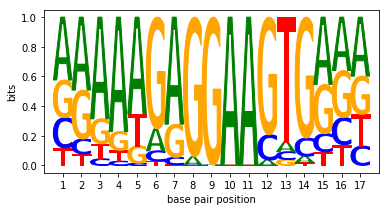

In [867]:
#plot the pwm 
plot_bases(spi1_pfm.transpose(),figsize=(6,3))

(<Figure size 432x216 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f4822546898>)

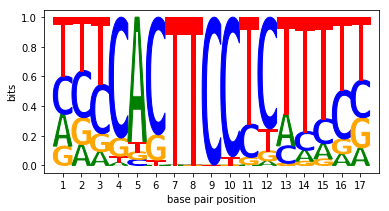

In [868]:
#plot the reverse complement of the pwm 
plot_bases(reverse_complement(spi1_pfm.transpose()),figsize=(6,3))

Note that the high confidence true positive SPI1 peaks we interpreted have deepLIFT score profiles resembling the 
reverse complement SPI1B motif. 

For each SNP in our bQTL scoring subset, we compute the maximum motif scan score along the 20 bp flanking the reference allele and the alternate allele. In this motif scan, we consider both the motif logo and the reverse complement of the motif logo. We then calculate the difference in the maximum motif score for the alternate allele and the reference allele. These scores should be higher for the significant subset of bQTLs compared to the non-significant subset of bQTLs. We verify that this is indeed the case. 

In peforming the motif scan, we normalize relative to the gc content of the SPI1 peaks in our dataset. Let's calculate this value.

In [772]:
spi1_peak_freqs=allele_freqs_from_bed("SPI1.narrowPeak.gz","hg19.genome.fa.gz")

read in bed file
extracted fasta


In [786]:
# a, c, g, t frequqencies 
print(spi1_peak_freqs)
GC_fraction=spi1_peak_freqs[1]+spi1_peak_freqs[2]
print(GC_fraction)

[0.2637494107713027, 0.23562266256894998, 0.23582911159450248, 0.26479881506524483]
0.47145177416345246


In [775]:
#Get the maximum sequence SPI1B scan scores for the reference allele 
to_score_bqtls['scan_post_scores']=np.max(
    get_motif_scores(
        bqtl_post_gen[0],
        ["SPI1B"],
        GC_fraction=GC_fraction
        pfm=spi1_pfm,
        include_rc=True)
    ,axis=2).squeeze()

In [776]:
#Get the maximum sequence SPI1B scan scores for the alternate alelle 
to_score_bqtls['scan_alt_scores']=np.max(
    get_motif_scores(
        bqtl_alt_gen[0],
        ["SPI1B"],
        GC_fraction=GC_fraction,
        pfm=spi1_pfm, 
        include_rc=True)
    ,axis=2).squeeze()

In [778]:
#Compute the scan score delta for the reference allele - alternate allele 
to_score_bqtls['scan_delta']=to_score_bqtls['scan_post_scores']-to_score_bqtls['scan_alt_scores']


We summarize our findings below: 

### bQTL interpretation summary: deep learning models vs motif scan  <a name='e'>
<a href=#outline>Home</a>

#### Motif scan 

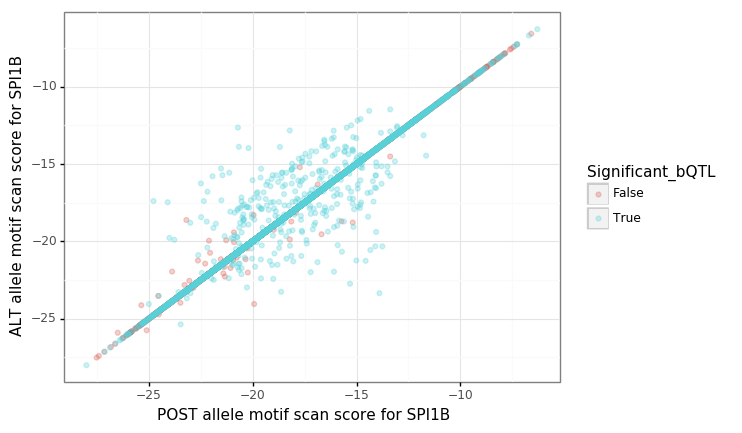

<ggplot: (-9223363290113990235)>


In [779]:
#We plot the motif scan scores for the POST and ALT alleles: 

print((ggplot(to_score_bqtls,aes(x="scan_post_scores",
                y="scan_alt_scores",
                group="Significant_bQTL",
                color="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("POST allele motif scan score for SPI1B")
             +ylab("ALT allele motif scan score for SPI1B")
             +theme_bw()))


Recall that we defined the bQTL logratio as the  logratio of the Post-CHIP frequency to the pre-CHIP frequency. Plotting the bQTL logratio vs the delta of the PWM scan score gives: 


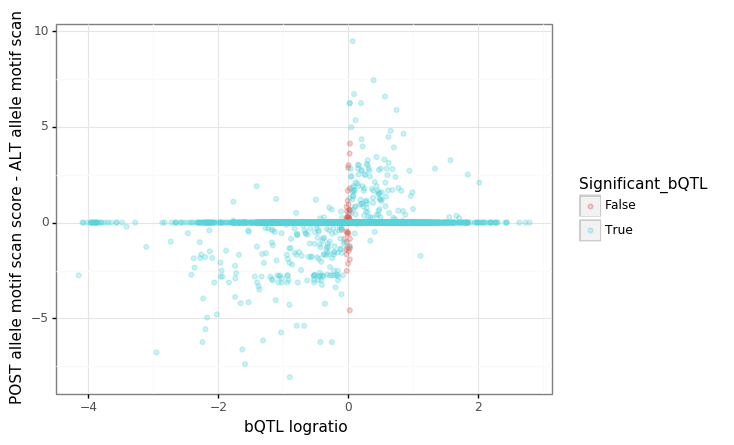

<ggplot: (8746742324719)>


In [780]:
print((ggplot(to_score_bqtls,aes(x="logratio",
                y="scan_delta",
                group="Significant_bQTL",
                color="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("bQTL logratio")
             +ylab("POST allele motif scan score - ALT allele motif scan")
             +theme_bw()))


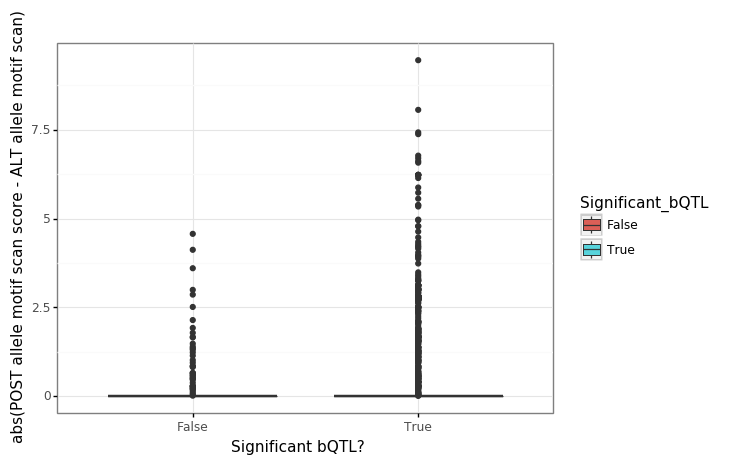

<ggplot: (-9223363290112054840)>


In [781]:
to_plot=pd.DataFrame({'Significant_bQTL':to_score_bqtls['Significant_bQTL'],
                     'abs_scan_delta':abs(to_score_bqtls['scan_delta'])})
print((ggplot(to_plot,aes(x="Significant_bQTL",
                y="abs_scan_delta",
                fill="Significant_bQTL",
                group="Significant_bQTL"))
             +geom_boxplot()
             +xlab("Significant bQTL?")
             +ylab("abs(POST allele motif scan score - ALT allele motif scan)")
             +theme_bw()))


#### Calibrated classification model predictions 

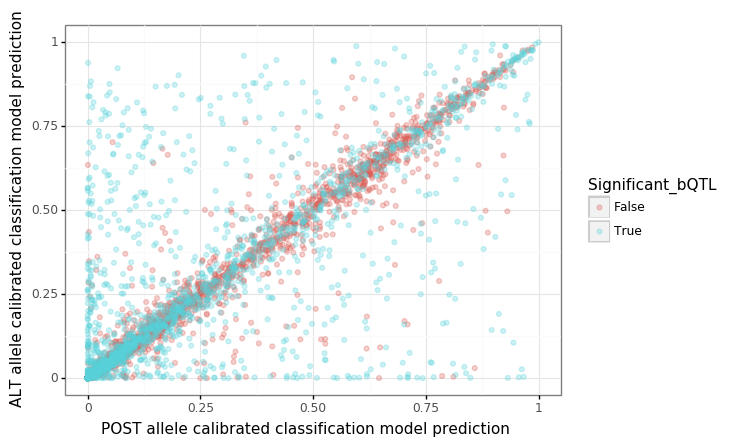

<ggplot: (8746750973511)>


In [556]:
#We plot the calibrated classification model predictions for the POST and ALT alleles
# (we examined this plot above, it is reproduced here for context with the other comparisons)

print((ggplot(to_score_bqtls,aes(x="post_classification_predictions",
                y="alt_classification_predictions",
                group="Significant_bQTL",
                color="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("POST allele calibrated classification model prediction")
             +ylab("ALT allele calibrated classification model prediction")
             +theme_bw()))

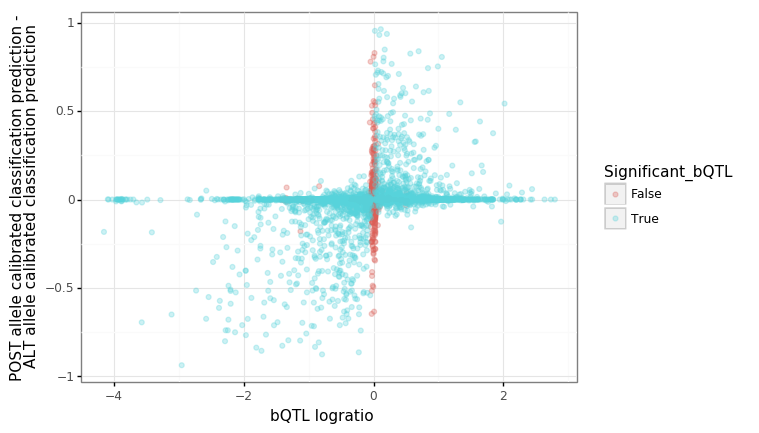

<ggplot: (-9223363290112339817)>


In [559]:
#We plot the logratio for the bQTLs vs the delta in calibrated predictions 

#we extract the fields we need for plotting
to_plot=pd.DataFrame({'Significant_bQTL':to_score_bqtls['Significant_bQTL'],
                      'logratio':to_score_bqtls['logratio'],
                     'delta_classification_predictions':
                      to_score_bqtls['post_classification_predictions']-
                      to_score_bqtls['alt_classification_predictions']})

print((ggplot(to_plot,aes(x="logratio",
                y="delta_classification_predictions",
                color="Significant_bQTL",
                fill="Significant_bQTL",
                group="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("bQTL logratio")
             +ylab("POST allele calibrated classification prediction - \nALT allele calibrated classification prediction")
             +theme_bw()))


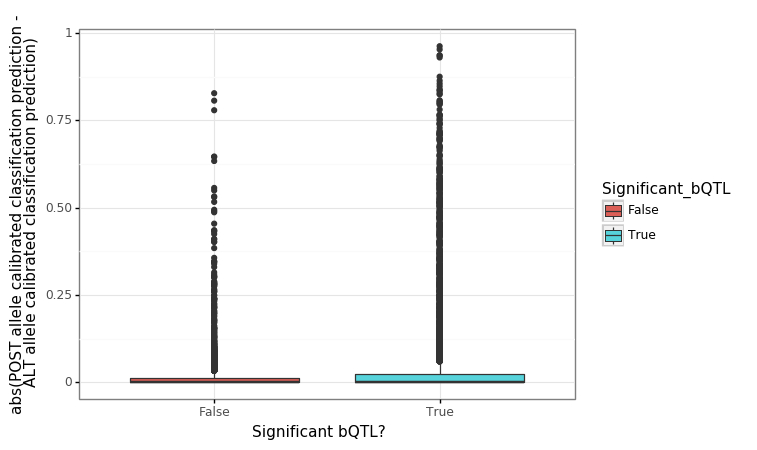

<ggplot: (-9223363290113174114)>


In [574]:
#We generate a boxplot of abs(POST calibrated prediction - ALT calibrated prediction) for
# the significant and the non-significant bQTLs

#we extract the fields we need for plotting
to_plot=pd.DataFrame({'Significant_bQTL':to_score_bqtls['Significant_bQTL'],
                     'abs_delta_classification_predictions':
                      abs(to_score_bqtls['post_classification_predictions']-
                      to_score_bqtls['alt_classification_predictions'])})


print((ggplot(to_plot,aes(x="Significant_bQTL",
                y="abs_delta_classification_predictions",
                fill="Significant_bQTL",
                group="Significant_bQTL"))
             +geom_boxplot()
             +xlab("Significant bQTL?")
             +ylab("abs(POST allele calibrated classification prediction - \nALT allele calibrated classification prediction)")
             +theme_bw()))


Finally, we restrict our analysis to the subset of bQTL's where the model's prediction changed most dramatically betwen the POST and ALT alleles. For this purpose, we subset the to_score_bqtls to those bQTL's where : 

* POST calibrated prediction > 0.7 and ALT calibrated prediction < 0.3
or 
* POST calibrated prediction < 0.3 and ALT calibrated prediction > 0.7 

In [581]:
condition1=(to_score_bqtls['post_classification_predictions']>0.7) & (to_score_bqtls['alt_classification_predictions']<0.3)
condition2=(to_score_bqtls['post_classification_predictions']<0.3) & (to_score_bqtls['alt_classification_predictions']>0.7)
to_keep=condition1 | condition2 
confident_to_score_bqtls=to_score_bqtls[to_keep]

In [583]:
confident_to_score_bqtls.shape

(86, 31)

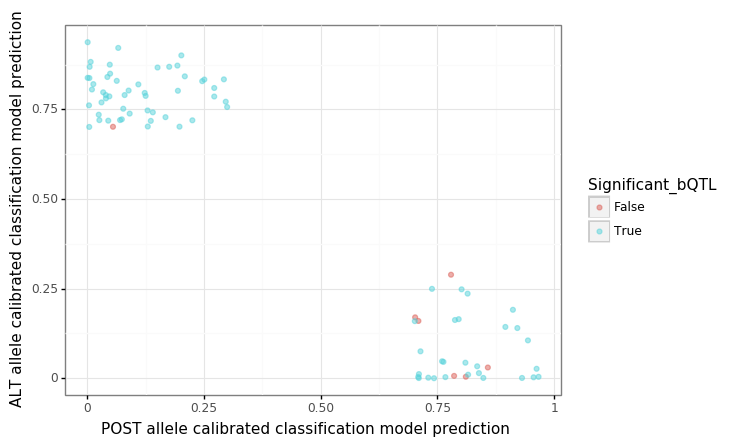

<ggplot: (8746741534258)>


In [585]:
#We plot the calibrated classification model predictions for the POST and ALT alleles
# (we examined this plot above, it is reproduced here for context with the other comparisons)

print((ggplot(confident_to_score_bqtls,aes(x="post_classification_predictions",
                y="alt_classification_predictions",
                group="Significant_bQTL",
                color="Significant_bQTL"))
             +geom_point(alpha=0.5)
             +xlab("POST allele calibrated classification model prediction")
             +ylab("ALT allele calibrated classification model prediction")
             +theme_bw()))

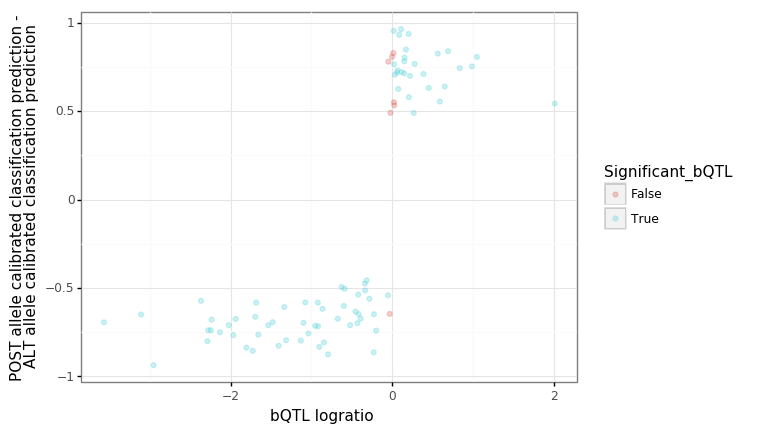

<ggplot: (8746741632264)>


In [586]:
#We plot the logratio for the bQTLs vs the delta in calibrated predictions 

#we extract the fields we need for plotting
to_plot=pd.DataFrame({'Significant_bQTL':confident_to_score_bqtls['Significant_bQTL'],
                      'logratio':confident_to_score_bqtls['logratio'],
                     'delta_classification_predictions':
                      confident_to_score_bqtls['post_classification_predictions']-
                      confident_to_score_bqtls['alt_classification_predictions']})

print((ggplot(to_plot,aes(x="logratio",
                y="delta_classification_predictions",
                color="Significant_bQTL",
                fill="Significant_bQTL",
                group="Significant_bQTL"))
             +geom_point(alpha=0.3)
             +xlab("bQTL logratio")
             +ylab("POST allele calibrated classification prediction - \nALT allele calibrated classification prediction")
             +theme_bw()))


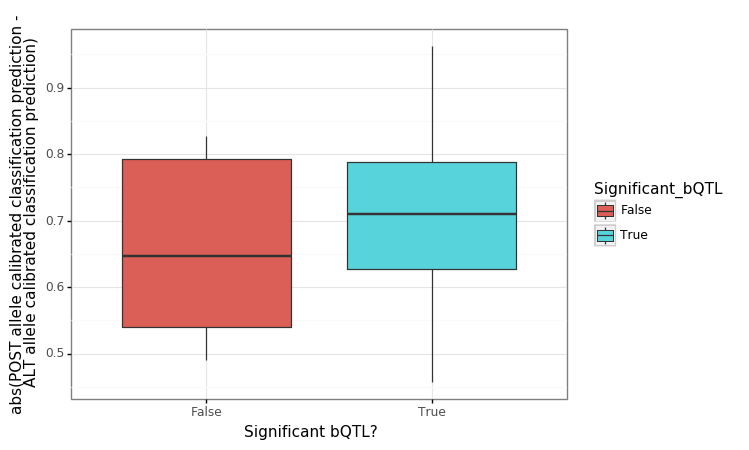

<ggplot: (-9223363290113307104)>


In [587]:
#We generate a boxplot of abs(POST calibrated prediction - ALT calibrated prediction) for
# the significant and the non-significant bQTLs

#we extract the fields we need for plotting
to_plot=pd.DataFrame({'Significant_bQTL':confident_to_score_bqtls['Significant_bQTL'],
                     'abs_delta_classification_predictions':
                      abs(confident_to_score_bqtls['post_classification_predictions']-
                      confident_to_score_bqtls['alt_classification_predictions'])})


print((ggplot(to_plot,aes(x="Significant_bQTL",
                y="abs_delta_classification_predictions",
                fill="Significant_bQTL",
                group="Significant_bQTL"))
             +geom_boxplot()
             +xlab("Significant bQTL?")
             +ylab("abs(POST allele calibrated classification prediction - \nALT allele calibrated classification prediction)")
             +theme_bw()))

Our visualizations of the logratio values vs the delta in motif scan scores and model predictions are quite informative. For the significant bQTL's, we see a positive correlation between logratio and delta in model predictions. However, this correlation is nearly non-existent for the motif scan, suggesting the higher sensitivity of the deep learning model. Let's test this out on a low-affinity transcription factor example: 


## Deep learning models are able to identify low-affinity TF-binding sites missed by motif scanning. <a name='11'>
<a href=#outline>Home</a>

Let's examine the region **chr5:107857257:107857288**. We have a highly significant bQTL within that region: 

In [942]:
to_score_bqtls[(to_score_bqtls['Chr']=="chr5") & (to_score_bqtls['position']>107857256) & (to_score_bqtls['position']<107857288)]

,Chr,position,Depth,ALTdepth,REFDepth,ALTallele,POSTallele,POSTfreq,prechipfreq,pvalue,...,alt_regression_preacts,alt_regression_predictions,max_classification_predictions,max_regression_predictions,Significant?,Significant_bQTL?,Significant_bQTL,scan_post_scores,scan_alt_scores,scan_delta
1622,chr5,107857273,842,38,804,A,G,0.954869,0.904784,0.000002,...,1.437376,0.994868,0.668202,0.999869,True,True,True,-24.376346,-24.376346,0.0


Let's extract the one-hot-encoded 1kb region centered at this position and 

1) interpret the region with our deep learning models

2) scan the region with the canonical SPI1 motif

We can compare how the two approaches perform. 

In [943]:
bqtl_post_gen=BQTLGenerator("SPI1.bQTLs.toScore.txt.gz",
                            "hg19.genome.fa.gz",
                            "POSTallele",
                            batch_size=num_to_score)
bqtl_alt_gen=BQTLGenerator("SPI1.bQTLs.toScore.txt.gz",
                           "hg19.genome.fa.gz",
                           "ALTallele",
                           batch_size=num_to_score)



In [944]:
post_seq=np.expand_dims(bqtl_post_gen[0][1622],axis=0)
alt_seq=np.expand_dims(bqtl_alt_gen[0][1622],axis=0)

getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


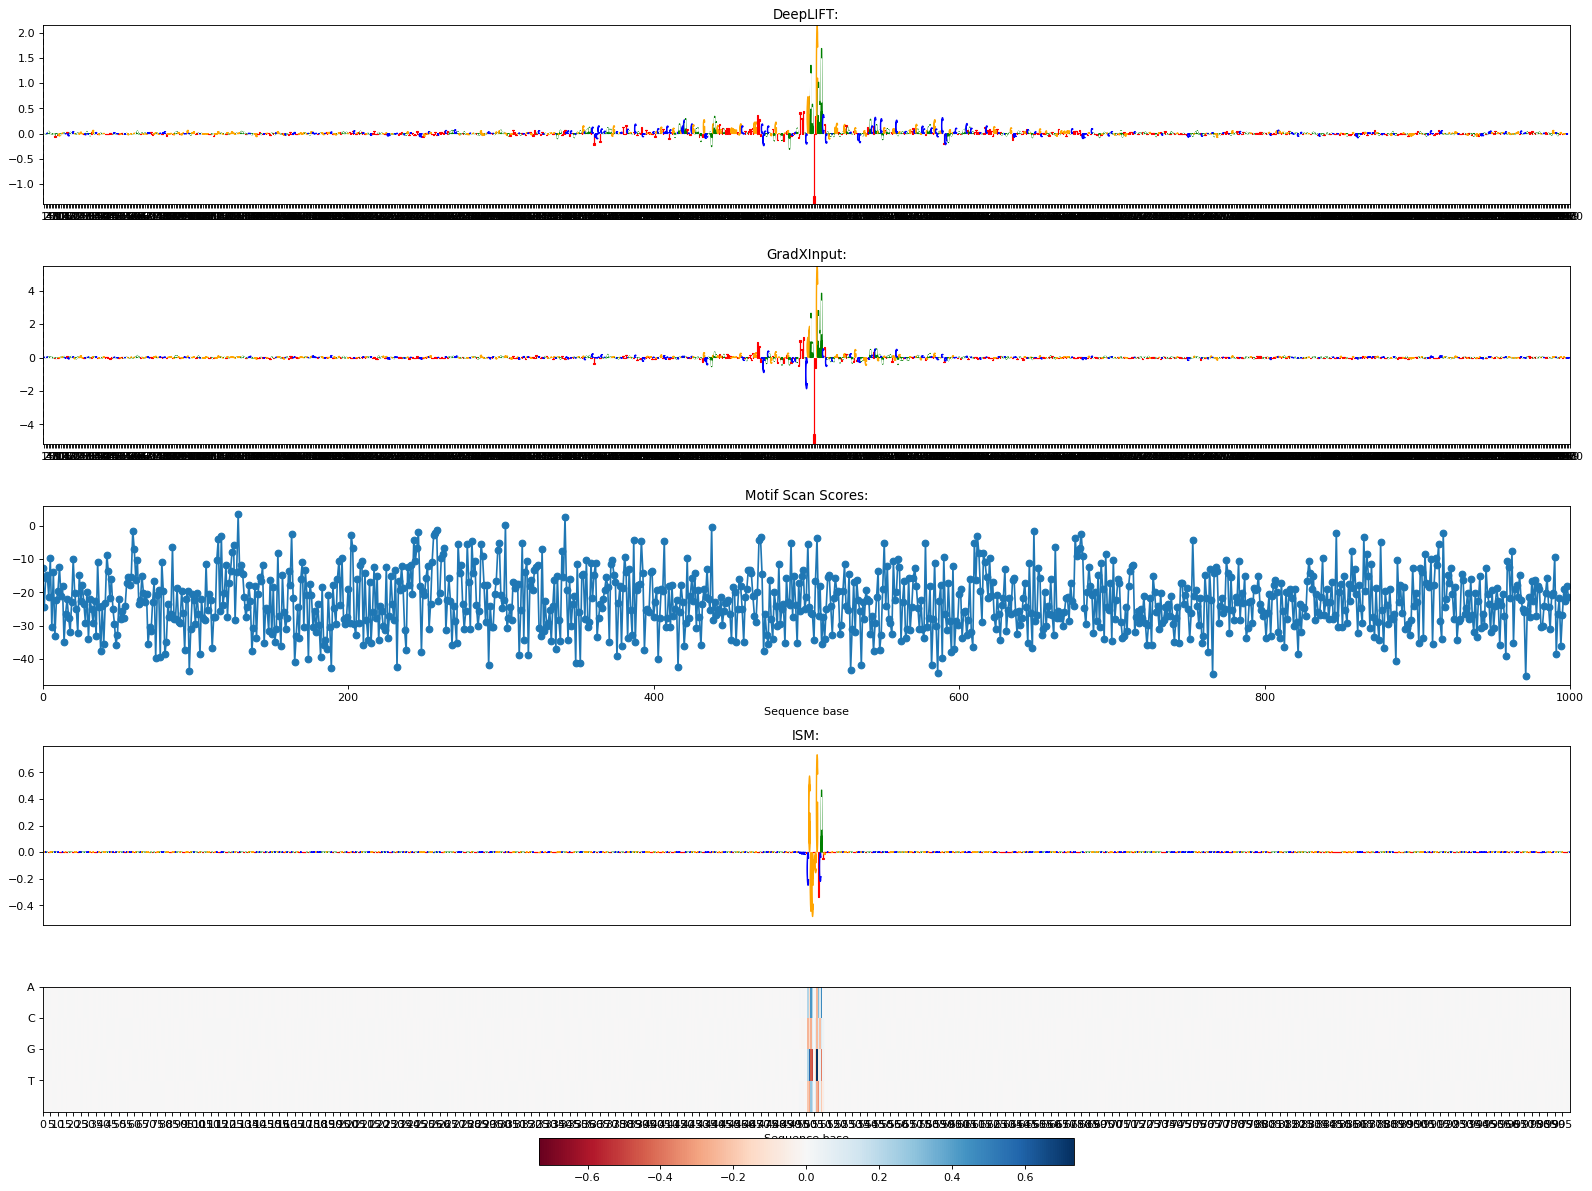

In [945]:
post_seq_classification_interpretations=multi_method_interpret(spi1_classification_model,
                                           post_seq,
                                           0,
                                           deeplift_score_func_classification,
                                           motif_names=['SPI1B'],
                                           pfm=spi1_pfm,
                                           GC_fraction=GC_fraction)

Let's zoom in to the bQTL: 

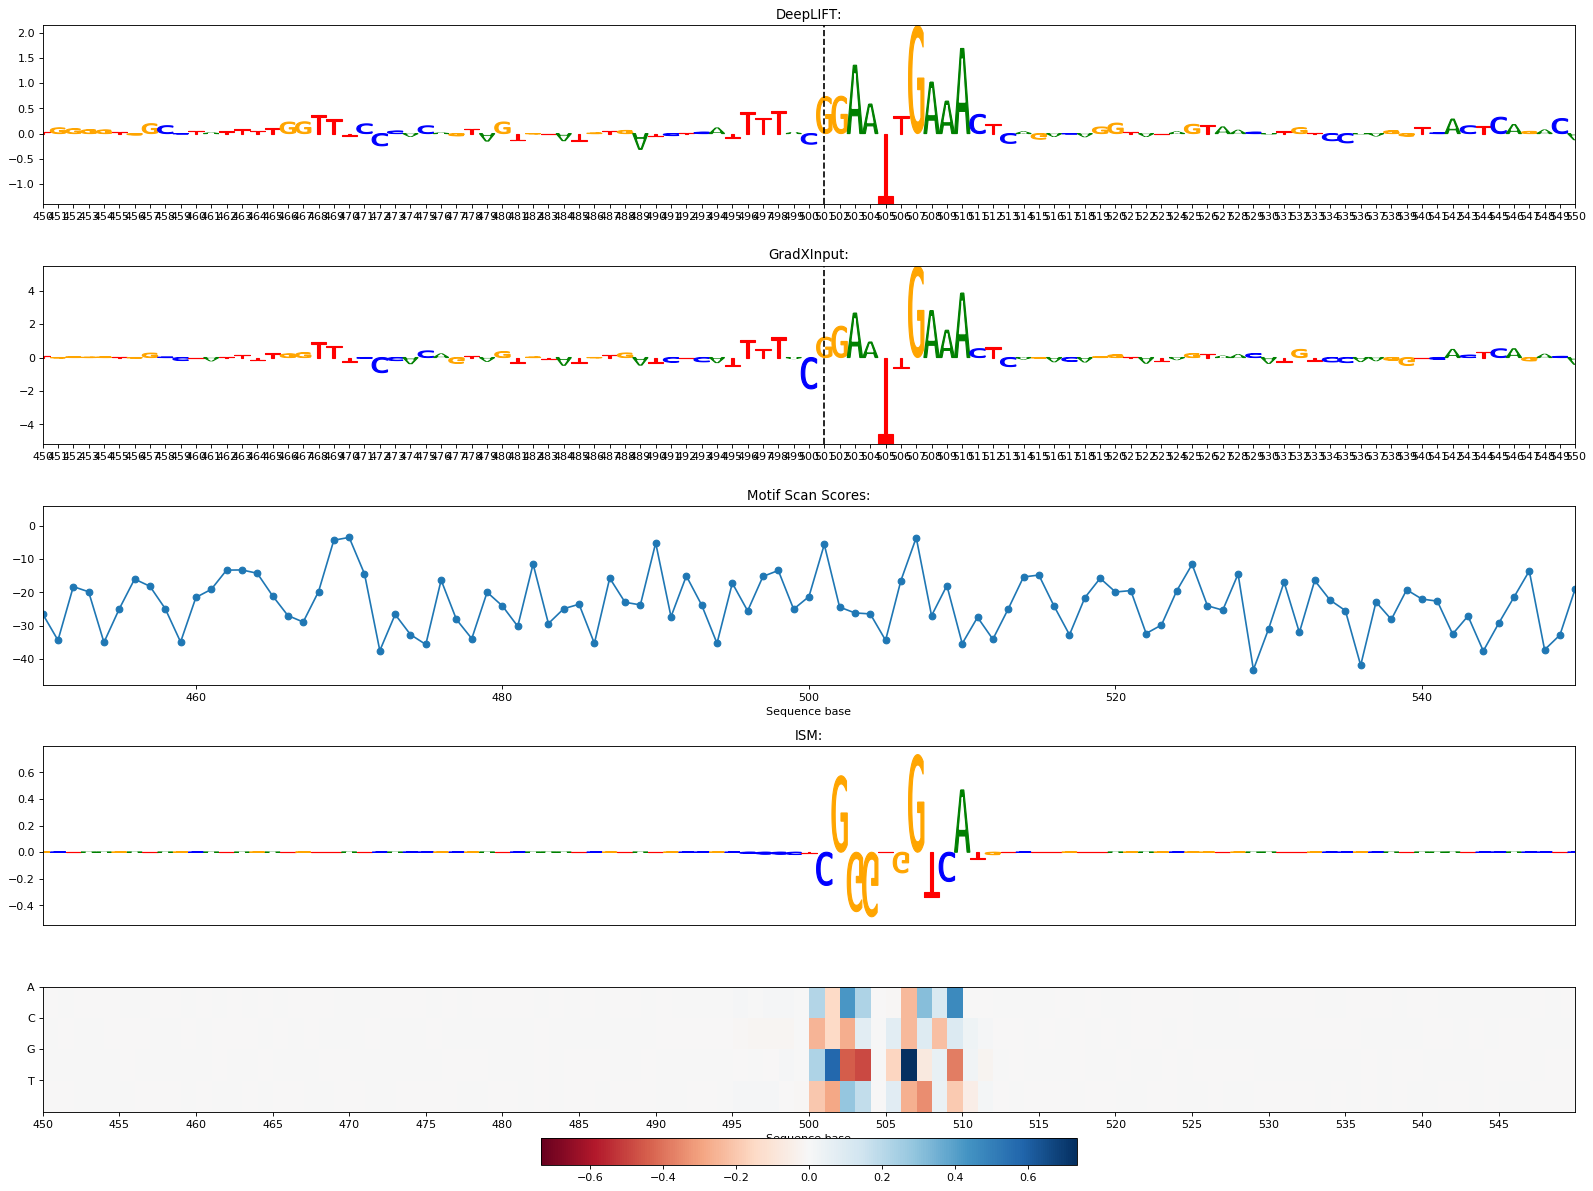

In [946]:
plot_all_interpretations([post_seq_classification_interpretations],post_seq,xlim=(450,550),snp_pos=501)

DeepLIFT identifies the region centered at the bQTL as important for predicting accessiblity, and the deepLIFT track matches the PWM for SPI1B quite well. The one exception is position 12 in the PWM -- our sequence has a "T" at that 
position, which both the model and the PWM strongly disfavor. However, the model is sensitive enough to recognize that the region is still a weak-affinity SPI1B site, whereas the motif scan lacks that sensitivity -- the motif scan track returns non-significant scores throughout the 1kb region. 



We repeat the analysis with the regression model: 

getting 'motif_scan' value
getting 'ism' value
ISM: task:0 sample:0
getting 'input_grad' value
getting 'deeplift' value


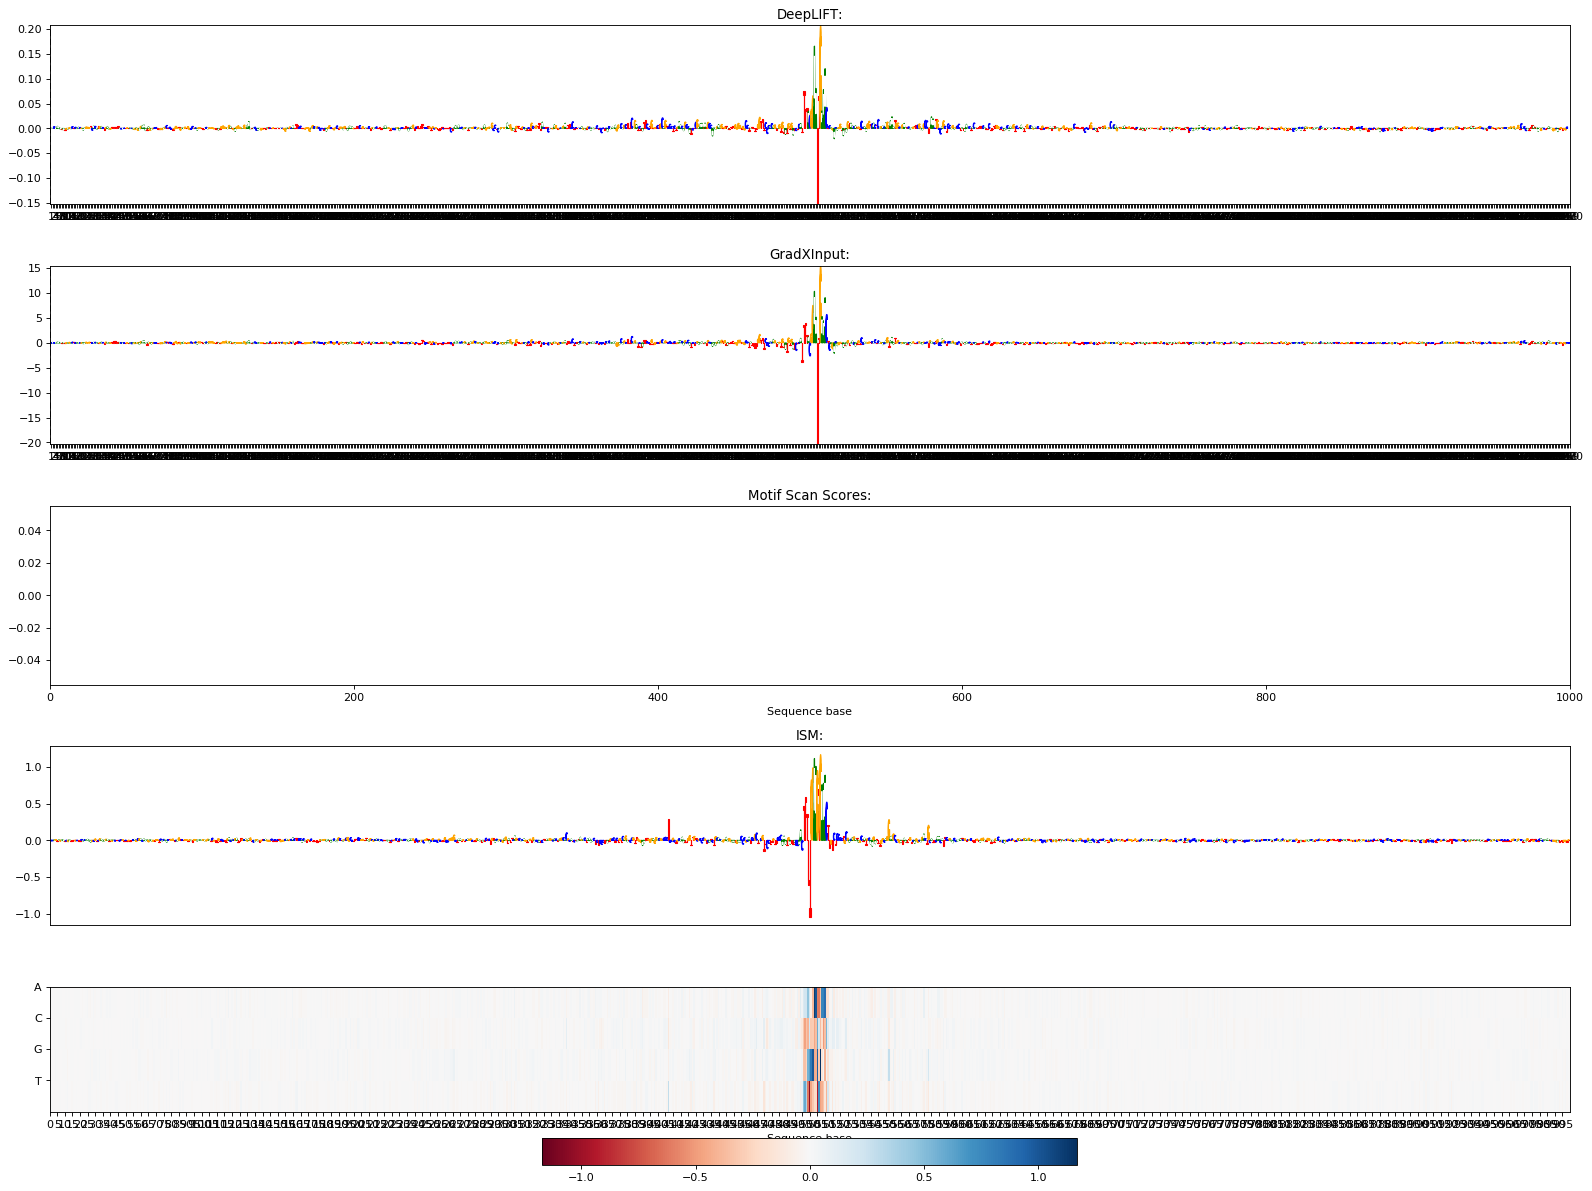

In [947]:
post_seq_regression_interpretations=multi_method_interpret(spi1_regression_model,
                                           post_seq,
                                           0,
                                           deeplift_score_func_regression,
                                           motif_names=['SPI1B'],
                                           pfm=spi1b_hocomoco_pwm,
                                           GC_fraction=GC_fraction)

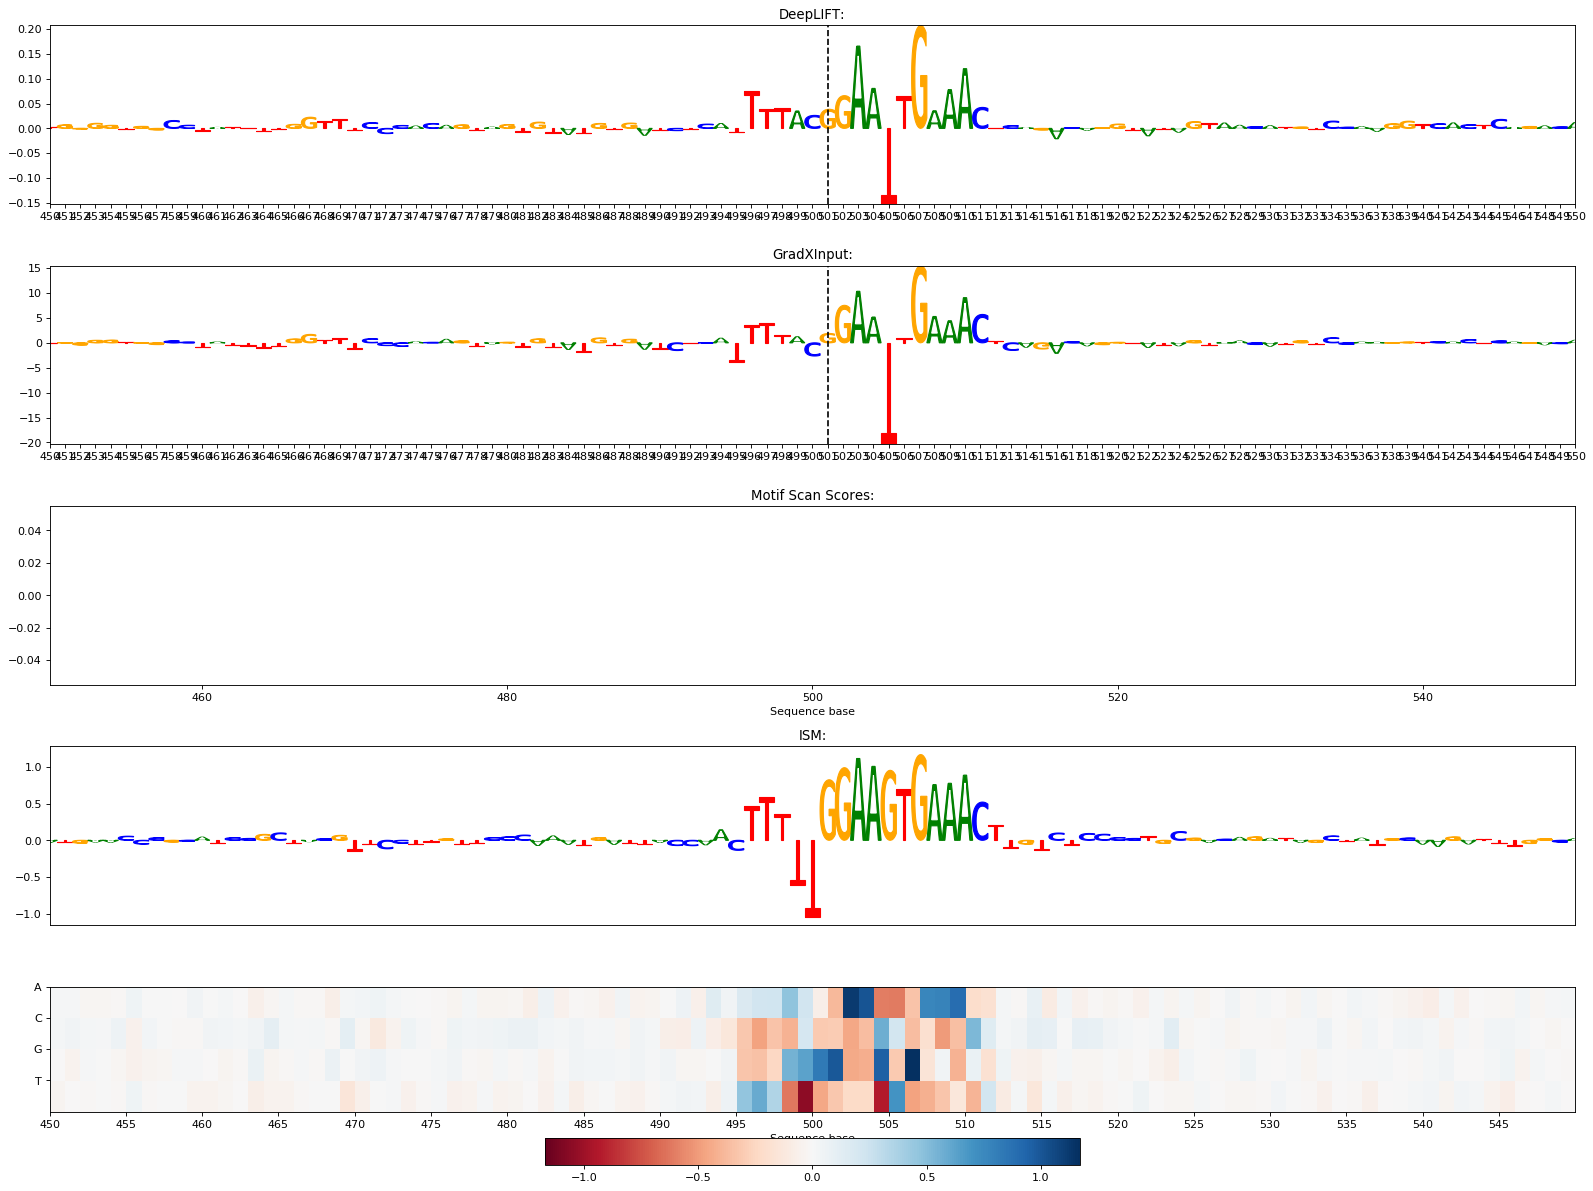

In [948]:
#Zooming in... 
plot_all_interpretations([post_seq_regression_interpretations],post_seq,xlim=(450,550),snp_pos=501)

Although our motif scan gave random-looking scores, let's see how our scan results compare relative to the "best possible" motif hit, the "worst possible" motif hit, and an "average" region selected from the genome. 

In [949]:
#identify indices of the bases with highest probability at each position in the PFM
best_match_bases=np.argmax(spi1_pfm,axis=0)
worst_match_bases=np.argmin(spi1_pfm,axis=0)
mask=np.zeros(spi1_pfm.shape)

best_hits=mask.copy() 
worst_hits=mask.copy() 

#generate one-hot encoding of the best and worst hits 
for index in range(mask.shape[1]): 
    cur_best_base=best_match_bases[index]
    cur_worst_base=worst_match_bases[index]
    best_hits[cur_best_base,index]=1
    worst_hits[cur_worst_base,index]=1

#generate a PFM consistent with the genome average base frequencies 
genome_background=np.tile(np.array([0.26,0.23,0.23,0.26]),(spi1_pfm.shape[1],1)).transpose()

#transpose the PFM's and expand dimensions to get a format compatible for motif scanning
best_hits=np.expand_dims(np.expand_dims(np.transpose(best_hits),axis=0),axis=0)
worst_hits=np.expand_dims(np.expand_dims(np.transpose(worst_hits),axis=0),axis=0)
genome_background=np.expand_dims(np.expand_dims(np.transpose(genome_background),axis=0),axis=0)

print("best hits:"+str(best_hits))
print("worst hits:"+str(worst_hits))
print("genome background:"+str(genome_background))

best hits:[[[[1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [0. 0. 1. 0.]
   [0. 0. 0. 1.]
   [0. 0. 1. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]
   [1. 0. 0. 0.]]]]
worst hits:[[[[0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]
   [0. 1. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]
   [0. 1. 0. 0.]
   [0. 1. 0. 0.]
   [0. 1. 0. 0.]
   [0. 0. 0. 1.]
   [0. 0. 1. 0.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 0. 0. 1.]
   [0. 1. 0. 0.]]]]
genome background:[[[[0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
   [0.26 0.23 0.23 0.26]
  

In [950]:
best_score=np.max(get_motif_scores(best_hits,['SPI1'],GC_fraction=GC_fraction,pfm=spi1_pfm,include_rc=False))
print(best_score)

16.55025560517656


In [951]:
worst_score=np.min(get_motif_scores(worst_hits,['SPI1'],GC_fraction=GC_fraction,pfm=spi1_pfm,include_rc=False))
print(worst_score)

-67.76367115835438


In [952]:
genome_background_score=np.max(get_motif_scores(genome_background,['SPI1'],GC_fraction=GC_fraction,pfm=spi1_pfm,include_rc=False))
print(genome_background_score)

-14.151933925614603


How does this compare to our observed score? 

In [953]:
post_score=get_motif_scores(post_seq,['SPI1'],GC_fraction=GC_fraction,pfm=spi1_pfm,include_rc=True)
print(np.max(post_score))


3.511370294699983


We overlay the best possible motif match, the worst possible motif match, the observed motif score track, and the genome background score track to illustrate that motif scanning does not effectively identify the SPI1 hit. 

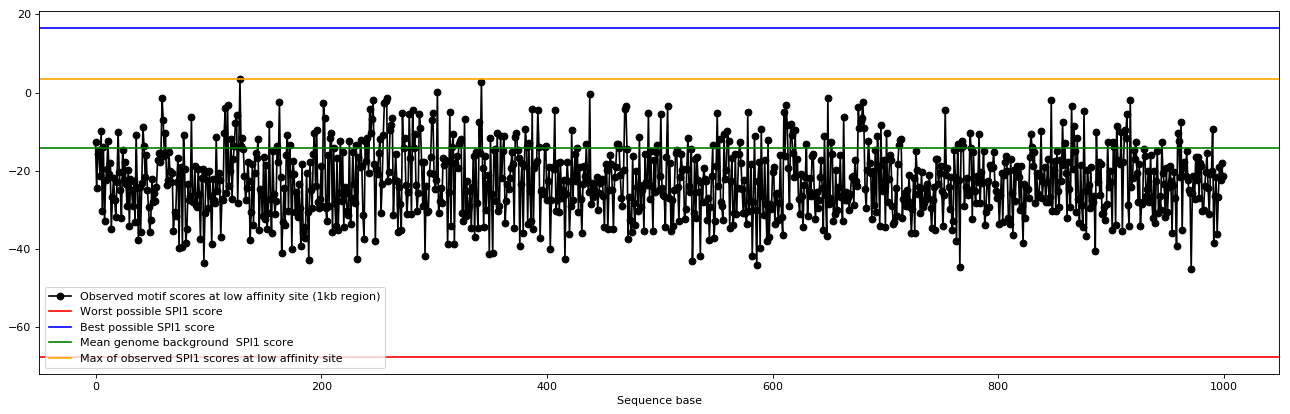

In [955]:
f,axes=plt.subplots(1,dpi=80,figsize=(20,6))
axes.plot(post_score.squeeze(), "-ko",label="Observed motif scores at low affinity site (1kb region)")
axes.axhline(y=worst_score,color="r",label="Worst possible SPI1 score")
axes.axhline(y=best_score,color="b",label="Best possible SPI1 score")
axes.axhline(y=genome_background_score,color="green",label="Mean genome background  SPI1 score")
axes.axhline(y=np.max(post_score),color="orange",label="Max of observed SPI1 scores at low affinity site ")
axes.set_xlabel("Sequence base")
plt.legend()
plt.show()


In summary, we conclude that the low-affinity SPI1 motif would have been missed by a classical PWM-scanning approach, but is clearly idenfitied via DeepLIFT and ISM analysis on classification and regression models. 